**<center><font size=5>Radio Signals Classification by SETI Data 👽</font></center>**
<center><font size=4>By Ben Shaver and Coral Hayoun</font></center>

----
# Abstract

##### **"Are we alone in the Universe?"**

It's one of the most profound human questions. Finding evidance of extraterrestrial life can fundamentally change our understanding of life and can offer new insights into biology, technology and the potential future of humanity.
As technology improves, we're finding new and more powerful ways to seek for answers.

**SETI**, or *the Search for Extraterrestrial Intelligence*, is an ongoing scientific effort to detect signs of intelligent life beyond Earth by analyzing radio signals from space. Every night, using the Allen Telescope Array (ATA) in northern California, the SETI Institute scans the sky at various radio frequencies, observing star systems with known exoplanets, searching for faint but persistent signals.

In order to refine the search for alien communication and focus on meaninigful signal patterns only, the detection system should be able to seperate them from the numerous natural and human-made radio emissions.


In this project, we will use our machine learning skills to accurately classify these signals into seven pre-defined categories, so that each category represents a different signal characteristics. This may allow the signal detection system to make better observational decisions and increase the efficiency of the nightly scans.

<br></br>
<center><img src="https://i.pinimg.com/originals/89/e6/91/89e6912b1225c43ed18b7c2b31069f77.jpg" width="600"></center>

(from [SETI Data - Kaggle competition](https://www.kaggle.com/datasets/tentotheminus9/seti-data)) <br></br>

----

##### **Table of Contents**
- <a href='#1'>1. Initial Settings | ⚙️</a>
- <a href='#2'>2. Exploratory Data Analysis | 🔦</a>
  - <a href='#2_1'>2.1. Data Loading</a>
  - <a href='#2_2'>2.2. Data Visualizing</a>
  - <a href='#2_3'>2.3. Feature Extraction</a>
    - <a href='#2_3_1'>2.3.1 Pixels Statistics</a>
    - <a href='#2_3_2'>2.3.2 Gaussian Noise Analysis</a>
    - <a href='#2_3_3'>2.3.3 Frequency Domain Analysis</a>
    - <a href='#2_3_4'>2.3.4 Signal Measurements</a>
  - <a href='#2_4'>2.4. Clustering</a>
    
  ----

# <a id='1'>1. Initial Settings | ⚙️</a>

##### 1. Install Libraries

In [2]:
%pip install -q pywt

##### 2. Import Libraries

In [161]:
# For operating system and file system
import os
import time
import logging
from pathlib import Path

# For basic functionality
import math

# For data manipulation and analysis
import numpy as np
import pandas as pd

# For frequency analysis
from scipy.fft import fft

# For Computer Vision Library
import cv2
from skimage import exposure
from skimage.feature import hog
from skimage.feature import local_binary_pattern

# For Deep Learning
import tensorflow as tf

# For Machine Learning
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import shuffle

# For data manipulation
from skimage.transform import resize
from skimage.restoration import estimate_sigma

# For data visualization
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio.v3 as iio
from scipy.stats import skew
import seaborn as sns

# For model persistence
import joblib

# For warning filtering
import warnings

In [4]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

##### 3. Libraries Version

In [5]:
print('np version:',np.__version__)
print('pd version:',pd.__version__)
print('tf version:',tf.__version__)
print('sklearn version:',sklearn.__version__)

np version: 1.26.4
pd version: 2.1.4
tf version: 2.16.1
sklearn version: 1.2.2


##### 4. Configuration

In [3]:
class CFG:
    # ------------------------------------#
    # Basic
    # ------------------------------------#
    debug = True
    runOnKaggle = False
    epochs = 1
    train_batch_size = 64
    validation_batch_size = 20
    data_augmentation_size = 5000
    test_batch_size = 64
    seed = 42
    k_fold = 4

    # ------------------------------------#
    # Paths
    # ------------------------------------#
    if runOnKaggle:
        base_folder_path = '/kaggle/input/seti-data/primary_small'
        tmp_storage_path = '/kaggle/tmp'
        workdir_folder_path = '/kaggle/working'
        logging_file = '/kaggle/logging.txt'
    else:
        base_folder_path = os.path.abspath('../../../Downloads/SETI Data/primary_small')
        tmp_storage_path = 'tmp'
        workdir_folder_path = 'working'
        logging_file = 'logging.txt'

    train_folder_path = f'{base_folder_path}/train'
    validation_folder_path = f'{base_folder_path}/valid'
    test_folder_path = f'{base_folder_path}/test'

# ------------------------------------#
# On Debug
# ------------------------------------#
if CFG.debug:
    CFG.epochs = 1
    CFG.train_batch_size = 50
    CFG.validation_batch_size = 25
    CFG.test_batch_size = 50
    CFG.data_augmentation_size = 500

##### 5. Utils Methods

In [191]:
def print_with_underline(text):
  underline = '\033[4m'
  reset = '\033[0m'
  print(f'{underline}{text}{reset}')

def get_files_in_folder(folder_path):
  return [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

def plot_features_distribution(features_list, features_df, figsize=(8, 4)):
  for feature in features_list:
      plt.figure(figsize=figsize)

      # sns.histplot needs conversion from float16 to float32
      features_df[feature] = features_df[feature].astype('float32')
      sns.histplot(features_df[features_df['category'] == 1][feature], bins=30, kde=True, color='blue', label='brightpixel')
      sns.histplot(features_df[features_df['category'] == 2][feature], bins=30, kde=True, color='orange', label='narrowband')
      sns.histplot(features_df[features_df['category'] == 3][feature], bins=30, kde=True, color='red', label='narrowbanddrd')
      sns.histplot(features_df[features_df['category'] == 4][feature], bins=30, kde=True, color='yellow', label='noise')
      sns.histplot(features_df[features_df['category'] == 5][feature], bins=30, kde=True, color='green', label='squarepulsednarrowband')
      sns.histplot(features_df[features_df['category'] == 6][feature], bins=30, kde=True, color='purple', label='squiggle')
      sns.histplot(features_df[features_df['category'] == 7][feature], bins=30, kde=True, color='brown', label='squigglesquarepulsednarrowband')
      
      plt.title(f'Distribution of {feature} by Category')
      plt.xlabel(feature)
      plt.ylabel('Count')
      plt.legend(title='Categories', loc='center left', fontsize='small', framealpha=0.9, bbox_to_anchor=(1, 0.5))
      plt.show()

def log(message, shouldPrint=False):
  if shouldPrint:
    print(message)
  logging.info(message)

def save_model(model, name):
  joblib.dump(model, f'{CFG.workdir_folder_path}/{name}.pkl')
  
def load_model(name):
  return joblib.load(f'{CFG.workdir_folder_path}/{name}.pkl')

def get_duration(start_time):
  return (time.time() - start_time) / 60

##### 6. Initial Methods

In [ ]:
# Create tmp Directory
if not os.path.exists(CFG.tmp_storage_path):
    os.makedirs(CFG.tmp_storage_path)

# Create working Directory
if not os.path.exists(CFG.workdir_folder_path):
    os.makedirs(CFG.workdir_folder_path)
    
# Create logging file
if not os.path.exists(CFG.logging_file):
    with open(CFG.logging_file, 'w'):
        pass

# Setup logger
logging.basicConfig(
    level=logging.INFO,  
    format='%(asctime)s - %(message)s',  
    filename=CFG.logging_file,  
    filemode='a'  
  )

# Remove unnecessary warnings
warnings.filterwarnings('ignore')

----

# <a id='2'>2. Exploratory Data Analysis | 🔦</a>


With our libraries and configurations set up, we can begin the exploratory data analysis (or EDA).

The **goal of EDA** is to understand the data underlying structure and patterns, identify important variables, detect outliers and anomalies and formulate hypotheses for further investigation. 

This process includes examining the distribution of the data, identifying patterns and trends, applying dimensionality reduction and clustering techniques, and visualizing the data to gain insights.

### <a id='2_1'>2.1. Data Loading</a>

Although our task may seem like a signal classification problem, it is actually an image classification challenge. We are working with radio spectrogram images, which visually represent the spectrum of frequencies in a signal over time. <br></br>
Our dataset is organized as follows:
- There are three main folders: `train`, `valid`, and `test`.
- Each of these folders contains seven subfolders, named **brightpixel**, **narrowband**, **narrowbanddrd**, **noise**, **squarepulsednarrowband**, **squiggle**, and **squigglesquarepulsednarrowband**. These subfolders represent the seven categories of radio signals.
- Inside each category folder, the data samples are stored as .png files, with each file corresponding to its respective category.
<br></br>

In [7]:
def count_data_samples_per_category(base_folder):
    data_samples_amount = 0

    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)

        if os.path.isdir(subfolder_path):
            subfolder_files = get_files_in_folder(subfolder_path)
            print(f'- for {subfolder}, there are {len(subfolder_files)} files')
            data_samples_amount += len(subfolder_files)
    
    print(f'in total, there are {data_samples_amount} files \n')

# Main
print_with_underline('train files:')
count_data_samples_per_category(CFG.train_folder_path)

print_with_underline('validation files:')
count_data_samples_per_category(CFG.validation_folder_path)

print_with_underline('test files:')
count_data_samples_per_category(CFG.test_folder_path)

train files:
- for brightpixel, there are 800 files
- for narrowband, there are 800 files
- for narrowbanddrd, there are 800 files
- for noise, there are 800 files
- for squarepulsednarrowband, there are 800 files
- for squiggle, there are 800 files
- for squigglesquarepulsednarrowband, there are 800 files
in total, there are 5600 files 

validation files:
- for brightpixel, there are 100 files
- for narrowband, there are 100 files
- for narrowbanddrd, there are 100 files
- for noise, there are 100 files
- for squarepulsednarrowband, there are 100 files
- for squiggle, there are 100 files
- for squigglesquarepulsednarrowband, there are 100 files
in total, there are 700 files 

test files:
- for brightpixel, there are 100 files
- for narrowband, there are 100 files
- for narrowbanddrd, there are 100 files
- for noise, there are 100 files
- for squarepulsednarrowband, there are 100 files
- for squiggle, there are 100 files
- for squigglesquarepulsednarrowband, there are 100 files
in tota

As we can see, the dataset consists of **5600 train examples** (with 800 samples per category), **700 validation examples** (100 samples per category) and **700 test examples** (also 100 samples per category). The relatively small size of the dataset may limit the accuracy of our model's predictions. If necessary, we can expand the dataset by generating additional synthetic samples to increase data diversity.

Now, let's explore some basic information about our data:

In [ ]:
def get_image_dimensions(image_path):
    image = Image.open(image_path)

    return image.size

In [17]:
def get_images_dimensions(base_folder):
    files_dimensions = []

    for category in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category)

        if os.path.isdir(category_path):
            for category_file in get_files_in_folder(category_path):
                width, height = get_image_dimensions(os.path.join(category_path, category_file))
                files_dimensions.append([width, height, category])

    return pd.DataFrame(files_dimensions, columns=['width', 'height', 'category'])

def display_images_dimensions(dimensions_df):
    if dimensions_df['width'].nunique() == 1 and dimensions_df['height'].nunique() == 1:
        width = dimensions_df['width'].iloc[0]
        height = dimensions_df['height'].iloc[0]
        print(f'image size is {width}x{height}')
    else:
        print('different images have different dimensions')   

# Main
print_with_underline('train files:')
display_images_dimensions(get_images_dimensions(CFG.train_folder_path))


print_with_underline('\nvalidation files:')
display_images_dimensions(get_images_dimensions(CFG.validation_folder_path))

print_with_underline('\ntest files:')
display_images_dimensions(get_images_dimensions(CFG.test_folder_path))

train files:
image size is 512x384

validation files:
image size is 512x384

test files:
image size is 512x384


In [ ]:
def is_image_grayscale(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if len(image.shape) < 3:
        return True
    elif image.shape[2] == 1:
        return True
    else:
        return False

In [23]:
def display_images_type(base_folder):
    rgb_files = 0
    grayscale_files = 0

    for category in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category)

        if os.path.isdir(category_path):
            for file in get_files_in_folder(category_path):
                if is_image_grayscale(os.path.join(category_path, file)):
                    grayscale_files += 1
                else:
                    rgb_files += 1
    
    print(f'- {rgb_files * 100 / (rgb_files + grayscale_files)}% of the images are RGB')
    print(f'- {grayscale_files * 100 / (rgb_files + grayscale_files)}% of the images are grayscale')

# Main
print_with_underline('train files:')
display_images_type(CFG.train_folder_path)

print_with_underline('\nvalidation files:')
display_images_type(CFG.validation_folder_path)

print_with_underline('\ntest files:')
display_images_type(CFG.test_folder_path)

train files:
- 100.0% of the images are RGB
- 0.0% of the images are grayscale

validation files:
- 100.0% of the images are RGB
- 0.0% of the images are grayscale

test files:
- 100.0% of the images are RGB
- 0.0% of the images are grayscale


It appears that all the dataset samples share the same size and type— **RGB format** with dimensions of **512x384**. This consistency suggests that any image modifications (such as resizing) will likely have a similar effect across all samples.

Before proceeding with these data samples, we need to ensure they are valid and suitable for analysis and modeling by checking the following:
- All files have the expected `.png` extension
- There are no corrupted files
- There are no blank content files

In [30]:
def is_file_extension_valid(image_path):
    image_extension = Path(image_path).suffix.lower()
    
    return image_extension in ['.png']

def is_file_content_blank(image):
    image_np = np.array(image)

    return np.all(image_np == image_np.flat[0])

In [32]:
def detect_invalid_data_samples(base_folder):
    corrupted_files = []
    blank_files = []
    invalid_extension_files = []

    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)

        if os.path.isdir(subfolder_path):
            for subfolder_file in get_files_in_folder(subfolder_path):
                try:
                    image_path = os.path.join(subfolder_path, subfolder_file)
                    with Image.open(image_path) as image:
                        image.verify()
                        # Verify function changes image object to invalid state so it shoud be reopen for further processing
                        image = Image.open(image_path)

                        if not is_file_extension_valid(image_path):
                            invalid_extension_files.append(subfolder_file)

                        if is_file_content_blank(image):
                            blank_files.append(subfolder_file)
                
                except (IOError, SyntaxError) as e:
                    corrupted_files.append(subfolder_file)
    
    print(f'- there are {len(corrupted_files)} corrupted files')
    print(f'- there are {len(blank_files)} blank files')
    print(f'- there are {len(invalid_extension_files)} invalid extension files')
    
# Main
print_with_underline('train files:')
detect_invalid_data_samples(CFG.train_folder_path)

print_with_underline('\nvalidation files:')
detect_invalid_data_samples(CFG.validation_folder_path)

print_with_underline('\ntest files:')
detect_invalid_data_samples(CFG.test_folder_path)

train files:
- there are 0 corrupted files
- there are 0 blank files
- there are 0 invalid extension files

validation files:
- there are 0 corrupted files
- there are 0 blank files
- there are 0 invalid extension files

test files:
- there are 0 corrupted files
- there are 0 blank files
- there are 0 invalid extension files


We have verified that all files have the correct `.png` extension and are free from corruption or blank content. Before proceeding with further analysis, let's create a DataFrame of our samples to facilitate easier future work:

In [48]:
def category_to_int_mapper(category):
    mapping = {
        'brightpixel': 1,
        'narrowband': 2,
        'narrowbanddrd': 3,
        'noise': 4,
        'squarepulsednarrowband': 5,
        'squiggle': 6,
        'squigglesquarepulsednarrowband': 7
    }

    return mapping[category]

def create_samples_data_frame(base_folder):
    data = []
    
    for category in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category)
        
        if os.path.isdir(category_path):
            for category_file in get_files_in_folder(category_path):
                file_path = os.path.join(category_path, category_file)
                file_id = os.path.splitext(category_file)[0]

                data.append([file_id, file_path, category_to_int_mapper(category)])
    
    return pd.DataFrame(data, columns=['file_id', 'file_path', 'category'])

# Main
train_df = create_samples_data_frame(CFG.train_folder_path)
validation_df = create_samples_data_frame(CFG.validation_folder_path)
test_df = create_samples_data_frame(CFG.test_folder_path)

In [158]:
train_df.head()

file_id                                          file_path  \
0  1003_brightpixel  c:\Users\koral\Downloads\SETI Data\primary_sma...   
1  1018_brightpixel  c:\Users\koral\Downloads\SETI Data\primary_sma...   
2  1023_brightpixel  c:\Users\koral\Downloads\SETI Data\primary_sma...   
3  1031_brightpixel  c:\Users\koral\Downloads\SETI Data\primary_sma...   
4  1035_brightpixel  c:\Users\koral\Downloads\SETI Data\primary_sma...   

   category  
0         1  
1         1  
2         1  
3         1  
4         1

We have successfully loaded our dataset and ensured its validity and reliability. Now, we can proceed with a more in-depth analysis:

### <a id='2_2'>2.2. Data Visualizing</a>

As previously mentioned, our data samples are `.png` files, organized into their respective category folders. Let's begin by writing general functions for visualizing the spectrogram files:

In [33]:
def get_image_path(base_folder, category, image_id):
    return '{}/{}/{}.png'.format(base_folder, category, image_id)

def get_grayscale_image(file_path):
    image = iio.imread(file_path)
    
    return cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)

def display_grayscale_images(files_path):
    _, axes = plt.subplots(1, 3, figsize=(15,5))

    for ax, file_path in zip(axes, files_path):
        image = get_grayscale_image(file_path)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        
    plt.show()

Now, we can move forward to explore and visualize the seven categories of radio signals, for better understanding of our data:<br></br>

1. **Brightpixel**: This category represents a localized region in a spectrogram where there is a significant increase in signal strength compared to the surrounding noise. It appears as a very bright, isolated spot or pixel on the frequency-time plot. Such occurrences can result from natural radio interference or brief, transient environmental events. **Brightpixels** are typically considered noise unless they exhibit a consistent pattern or appear across multiple channels or time intervals, which may suggest a potential artificial source.

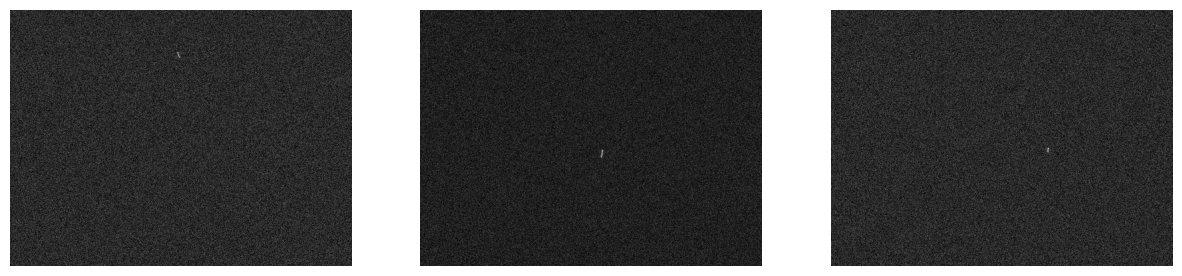

In [38]:
paths = [
    get_image_path(CFG.train_folder_path, 'brightpixel', '423_brightpixel'),
    get_image_path(CFG.train_folder_path, 'brightpixel', '49_brightpixel'),
    get_image_path(CFG.train_folder_path, 'brightpixel', '175_brightpixel')
]

display_grayscale_images(paths)

2. **Narrowband**: This category refers to a signal that occupies a very small bandwidth, meaning it covers a narrow range of frequencies. In a spectrogram, it appears as thin, well-defined lines or bands across the time-frequency plot, indicating that the signal is concentrated at a specific frequency over time. **Narrowband** signals are particularly interesting in SETI because natural astrophysical sources rarely produce emissions with such narrow frequency ranges. A true **narrowband** signal could suggest a non-natural origin, potentially indicating the presence of technology.

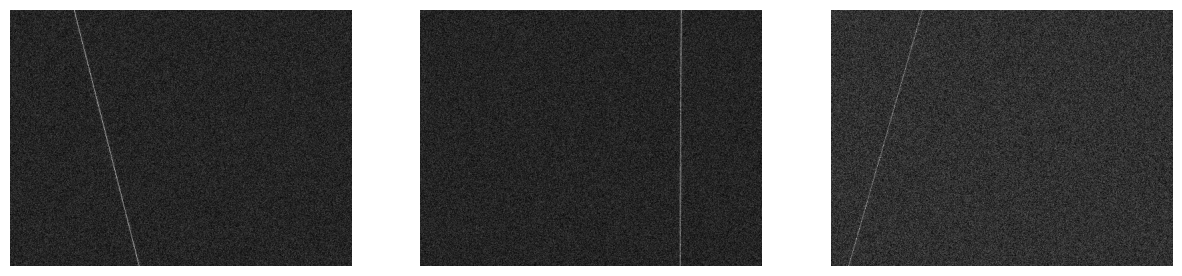

In [40]:
paths = [
    get_image_path(CFG.train_folder_path, 'narrowband', '165_narrowband'),
    get_image_path(CFG.train_folder_path, 'narrowband', '45_narrowband'),
    get_image_path(CFG.train_folder_path, 'narrowband', '61_narrowband')
]

display_grayscale_images(paths)

3. **Narrowbanddrd** (Narrowband Drift): This category refers to a **narrowband** signal that exhibits some form of drift over time, appearing as a concave line in the spectrogram. This drift may occur because the source of the signal is moving relative to the observer. The frequency shift could be attributed to the Doppler effect, resulting from the relative motion between the source and the receiver. Therefore, these signals may indicate a moving or rotating extraterrestrial transmitter.


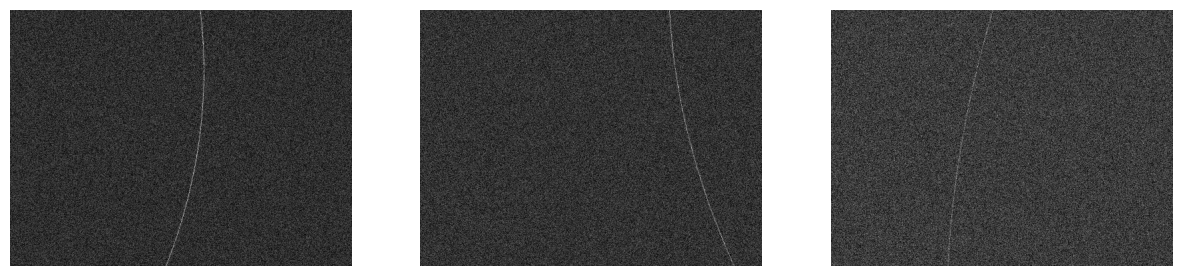

In [41]:
paths = [
    get_image_path(CFG.train_folder_path, 'narrowbanddrd', '118_narrowbanddrd'),
    get_image_path(CFG.train_folder_path, 'narrowbanddrd', '46_narrowbanddrd'),
    get_image_path(CFG.train_folder_path, 'narrowbanddrd', '202_narrowbanddrd')
]

display_grayscale_images(paths)

4. **Noise**: This category refers to any signal or pattern that does not exhibit a clear or consistent structure, making it unlikely to be of artificial origin. It may manifest as random fluctuations in intensity across the spectrogram. Noise signal might be caused by natural sources, such as cosmic background radiation or interference from Earth-based technology and it generally does not suggest an extraterrestrial source. In SETI, noise reduction is crucial for identifying true candidate signals.

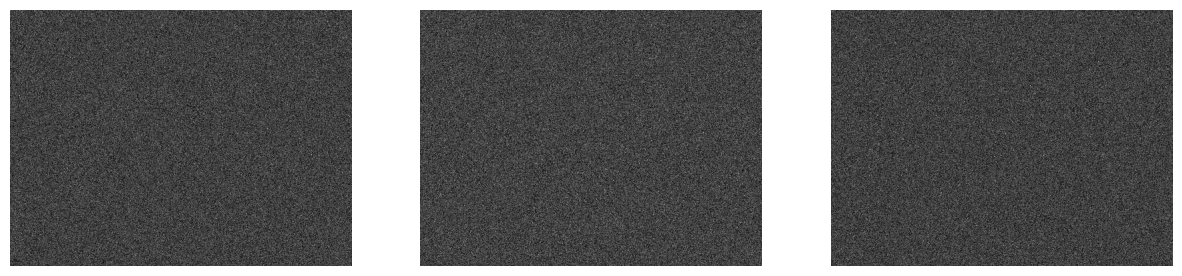

In [42]:
paths = [
    get_image_path(CFG.train_folder_path, 'noise', '761_noise'),
    get_image_path(CFG.train_folder_path, 'noise', '106_noise'),
    get_image_path(CFG.train_folder_path, 'noise', '215_noise')
]

display_grayscale_images(paths)

5. **Squarepulseandnarrowband**: This type of signal combines characteristics of both **square pulse** and **narrowband** signals. It exhibits a narrow frequency width like **narrowband** signals but appears in bursts or **square pulse**-like patterns over time. The combination of **narrowband** and **square pulses** could suggest a modulated signal or some form of structured emission, which may be indicative of technology.

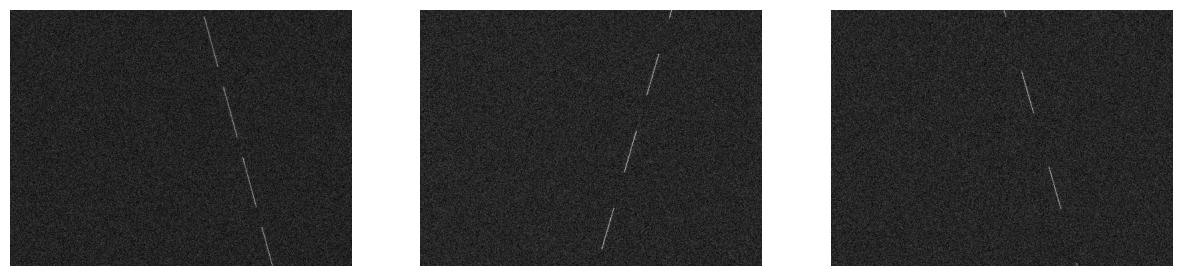

In [43]:
paths = [
    get_image_path(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband'),
    get_image_path(CFG.train_folder_path, 'squarepulsednarrowband', '65_squarepulsednarrowband'),
    get_image_path(CFG.train_folder_path, 'squarepulsednarrowband', '147_squarepulsednarrowband')
]

display_grayscale_images(paths)

6. **Squiggle**: Squiggle signals exhibit a curvy or wavy pattern in the spectrogram. Their frequency varies in a more irregular and dynamic way compared to **narrowbanddrd** signals, leading to a squiggly appearance. While the origins of squiggle signals can sometimes be attributed to natural astrophysical processes, like pulsar emissions, they may also suggest a non-standard form of modulation in an artificial transmission.

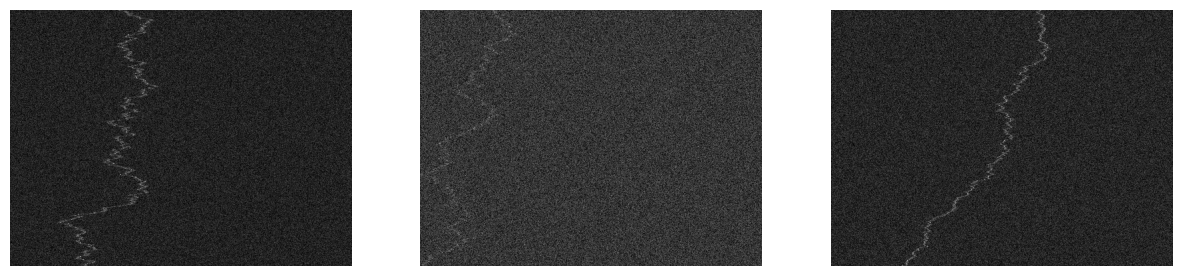

In [44]:
paths = [
    get_image_path(CFG.train_folder_path, 'squiggle', '21_squiggle'),
    get_image_path(CFG.train_folder_path, 'squiggle', '83_squiggle'),
    get_image_path(CFG.train_folder_path, 'squiggle', '131_squiggle')
]

display_grayscale_images(paths)

7. **Squigglesquarepulseandnarrowband**: This category combines features from **squiggle**, **squarepulse**, and **narrowband** signal types. In a spectrogram, it may appear as a complex pattern consisting of wavy lines (**squiggles**), **square pulses**, and **narrowband** components, potentially overlapping or interwoven. Such complex signal patterns are intriguing in the search for extraterrestrial intelligence because they might imply a sophisticated modulation technique or a mix of different signal types. They are more challenging to analyze due to their varied nature but could potentially carry meaningful information.

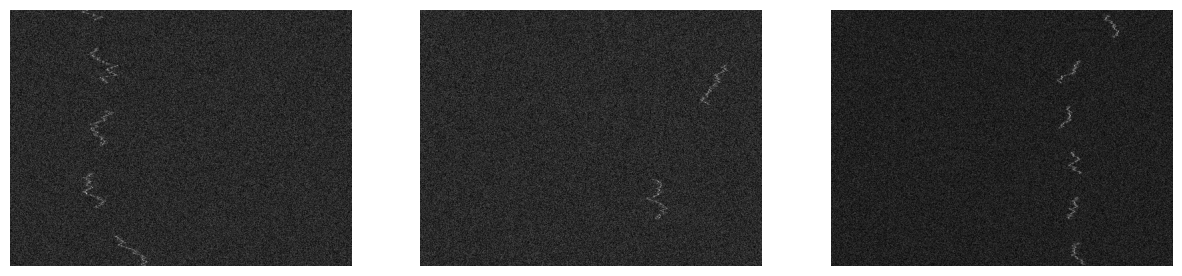

In [45]:
paths = [
    get_image_path(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband'),
    get_image_path(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '129_squigglesquarepulsednarrowband'),
    get_image_path(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '249_squigglesquarepulsednarrowband')
]

display_grayscale_images(paths)

Interesting patterns emerge when we examine the visual similarities between different signal types, such as: **Squigglesquarepulseandnarrowband** with **Squiggle**, **Narrowband** with **Narrowbanddrd** and **Squarepulseandnarrowband**, and **Noise** with **Brightpixel**. In the following sections, we will closely examine the characteristics of these categories in an effort to identify distinguishing features among them.

### <a id='2_3'>2.3. Feature Extraction</a>
**Feature Extraction** is a crucial step in analyzing our signal dataset, as it involves identifying distinctive characteristics that can effectively differentiate between various signal types. By quantifying attributes such as amplitude, frequency, and statistical measures, we can enhance our understanding of each category's unique properties. This process improves the overall accuracy of our signal classification models.

#### <a id='2_3_1'>2.3.1 Pixels Statistics</a>

We will start our *Feature Extraction* by exploring the **histogram** of random signals. A **histogram** represents the distribution of pixel intensities in an image, providing valuable insight into how signal characteristics — such as amplitude and frequency — are distributed. This visualization facilitates the identification of patterns and anomalies within the signals, allowing for more effective analysis.

To perform this analysis, we will work with the grayscale representation of our images, dividing the pixels into four groups based on brightness ranges, labeled as Q1 through Q4:

In [36]:
pixel_value_range = 256

def image_brightness_ranges(grayscale_image):
    ranges = [(0, 64), (64, 128), (128, 192), (192, 256)]
        
    counts = []
    for lower, upper in ranges:
        counts.append(np.sum((grayscale_image >= lower) & (grayscale_image < upper)))

    return counts

In [38]:
def plot_pixel_brightness_histogram(base_folder, category, image_id):
    _, axis = plt.subplots(1, 2, figsize=(10,2)) 
    
    grayscale_image = get_grayscale_image(get_image_path(base_folder, category, image_id))
    
    axis[0].set_title(category)
    axis[0].imshow(grayscale_image, aspect='auto', cmap='gray')
    
    # Determine the quartiles
    q1 = (pixel_value_range / 4) * 1
    q2 = (pixel_value_range / 4) * 2
    q3 = (pixel_value_range / 4) * 3
    q4 = (pixel_value_range / 4) * 4
    
    axis[1].hist(grayscale_image.flatten(), bins=pixel_value_range, density=True, color='blue', alpha=0.3)
    axis[1].set_xlim(0, 255)
    
    # Add vertical lines for quartiles
    axis[1].axvline(q1, color='black', linestyle='--')
    axis[1].axvline(q2, color='black', linestyle='--')
    axis[1].axvline(q3, color='black', linestyle='--')

    # Add text annotations for quartiles
    axis[1].text(q1 / 2, 0.02, 'Q1', fontsize=12, ha='center')
    axis[1].text((q1 + q2) / 2, 0.02, 'Q2', fontsize=12, ha='center')
    axis[1].text((q2 + q3) / 2, 0.02, 'Q3', fontsize=12, ha='center')
    axis[1].text((q3 + 256) / 2, 0.02, 'Q4', fontsize=12, ha='center')

    # Add labels and title
    axis[1].set_xlabel('Pixel Color (Brightness)')
    axis[1].set_ylabel('Normalized Frequency')
    axis[1].set_title(f"Brightness counts: {image_brightness_ranges(grayscale_image)}")
    axis[1].grid(True)
    
    plt.show

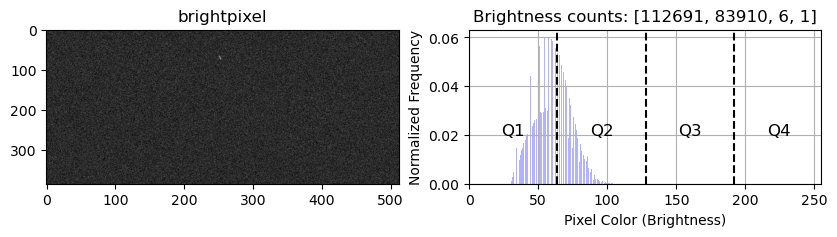

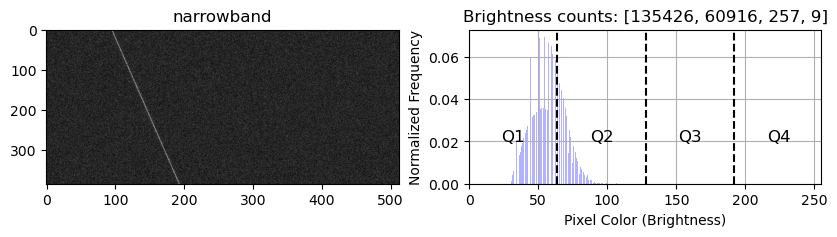

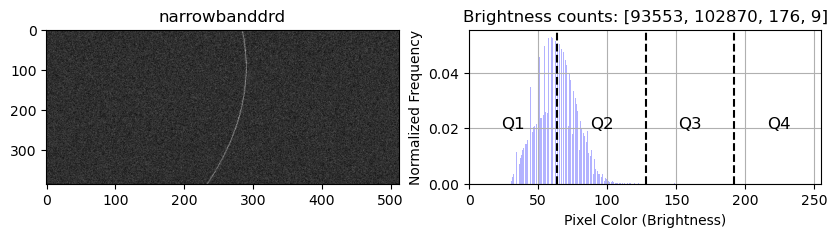

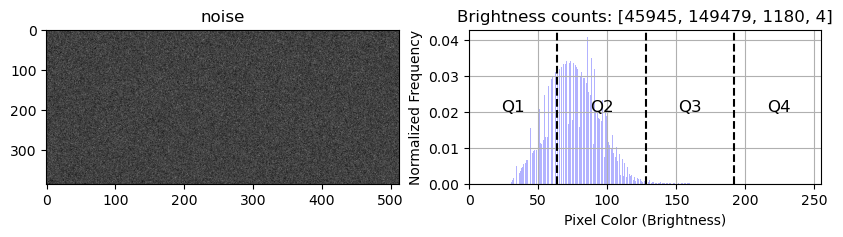

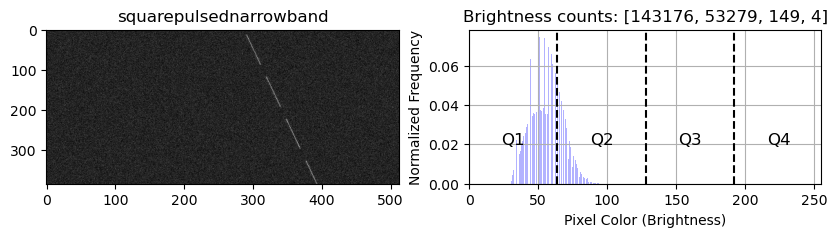

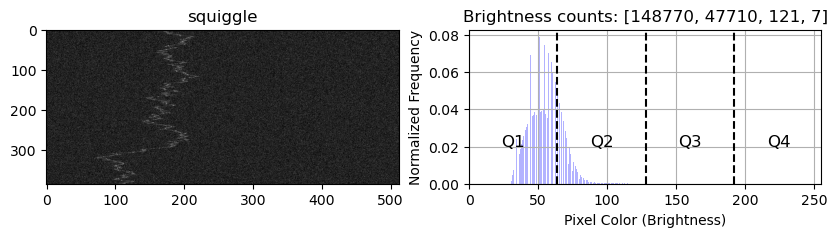

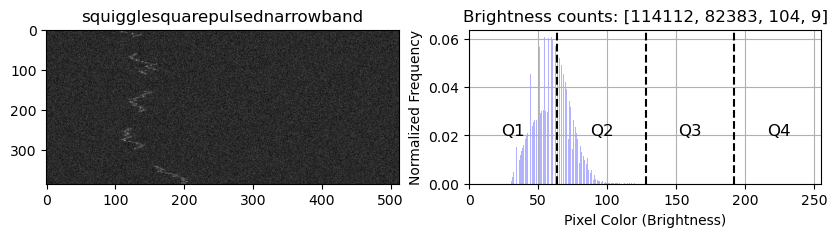

In [39]:
# Main
plot_pixel_brightness_histogram(CFG.train_folder_path, 'brightpixel', '423_brightpixel')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'narrowband', '165_narrowband')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'narrowbanddrd', '118_narrowbanddrd')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'noise', '761_noise')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'squiggle', '21_squiggle')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband')

Nice! We can observe subtle differences between the histograms of some categories, but these distinctions are certainly not sufficient.  In addition to analyzing the pixel brightness in each spectrogram sample, further examination of the characteristics of pixel brightness distribution is necessary. Key statistical measures such as **mean**, **variance**, and **skewness** can provide valuable insights:
- **Mean** The average pixel brightness, offering a general sense of the brightness level across the image.
- **Variance** A measure of how much the pixel brightness values differ from the *mean*, indicating the degree of spread in the distribution.
- **Skewness** A statistical measure that describes the asymmetry of the data distribution around the *mean*. It helps us understand whether the distribution is skewed to the left (negative skew) or right (positive skew), which can indicate underlying patterns in the data.


By calculating these statistics, we can enhance our understanding of the pixel brightness distribution and improve our ability to differentiate between signal categories:

In [43]:
def get_pixels_statistical_measures(grayscale_image):
    # Flatten the image to a 1D array of pixel intensities
    pixels = grayscale_image.flatten()
    
    return (np.mean(pixels), np.var(pixels), skew(pixels))

# Main
grayscale_image = get_grayscale_image(get_image_path(CFG.train_folder_path, 'narrowbanddrd', '118_narrowbanddrd'))
statistical_measure = get_pixels_statistical_measures(grayscale_image)

print(f'mean: {statistical_measure[0]}, variance: {statistical_measure[1]}, skewness: {statistical_measure[2]}')

mean: 64.49246215820312, variance: 213.2262005051598, skewness: 0.28370592528231536


Great, now we can explore these metrics across the entire training set:

In [49]:
statistical_measures_list = []

for _, row in train_df.iterrows():
    image_id = row['file_id']
    image = get_grayscale_image(row['file_path'])

    mean, variance, skewness = get_pixels_statistical_measures(image)

    statistical_measures_list.append({
        'id': row['file_id'],
        'category': row['category'],
        'mean': mean,
        'variance': variance,
        'skewness': skewness
    })

statistical_measures_df = pd.DataFrame(statistical_measures_list)

After collecting these features, let's analyze them:

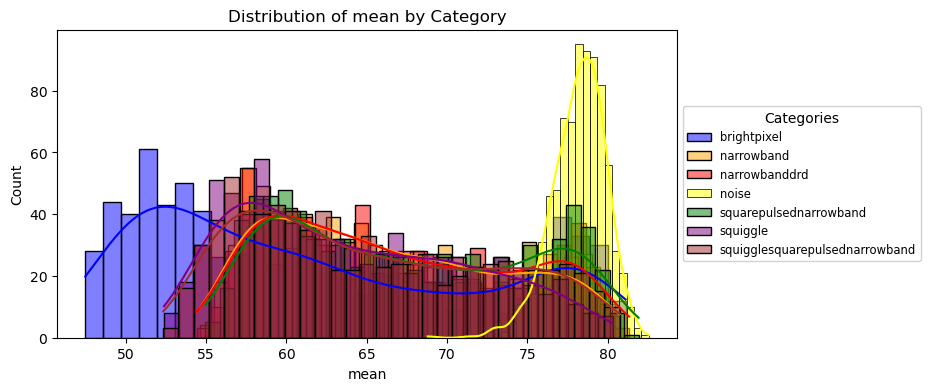

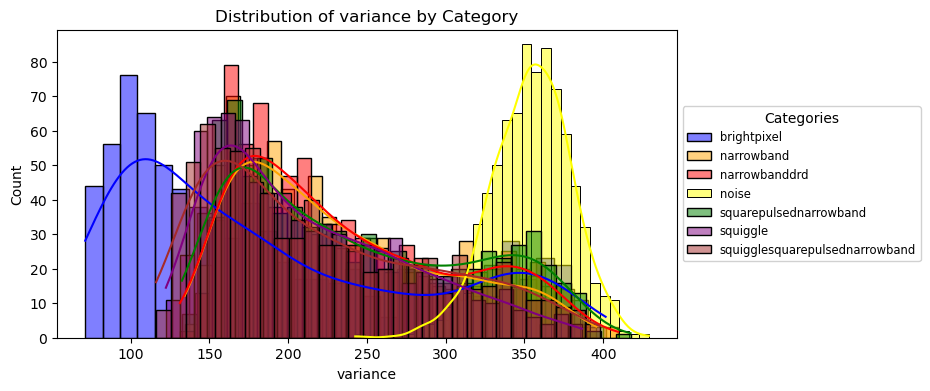

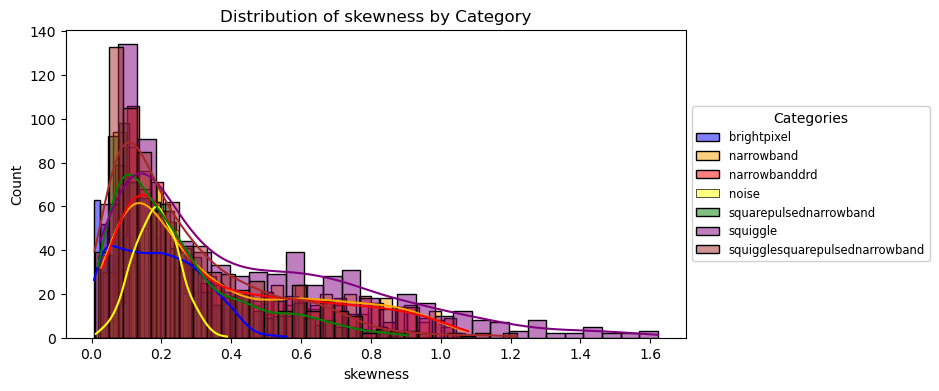

In [192]:
plot_features_distribution(['mean', 'variance', 'skewness'], statistical_measures_df)

Great! As we can see, the mean and the variance are exellent separators between the **noise** category to the rest, and can potentially be good separators between the **brightpixel** category to the rest as well. 

We will move now to our next feature:

#### <a id='2_3_2'>2.3.2 Gaussian Noise Analysis</a>
`Gaussian Noise`, also known as normal noise, is a fundamental concept in signal processing and statistics. It is called *Gaussian* because its probability density function (*PDF*) follows a Gaussian (normal) distribution. By estimating the standard deviation of the Gaussian noise in the images, we can gain valuable insights into the noise level present and its impact on image quality.

To analyze the standard deviation of Gaussian noise, we will use the `estimate_sigma` function, which estimates the noise level in an image based on the decomposition of its frequency components:

In [56]:
def get_gaussian_noise(image):
    return estimate_sigma(image, channel_axis=None, average_sigmas=True)

In [57]:
gaussian_noise_list = []

for _, row in train_df.iterrows():
    image_id = row['file_id']
    image = get_grayscale_image(row['file_path'])

    noise = get_gaussian_noise(image)

    gaussian_noise_list.append({
        'id': row['file_id'],
        'category': row['category'],
        'noise': noise
    })

gaussian_noise_df = pd.DataFrame(gaussian_noise_list)

Now we can analyze it as well:

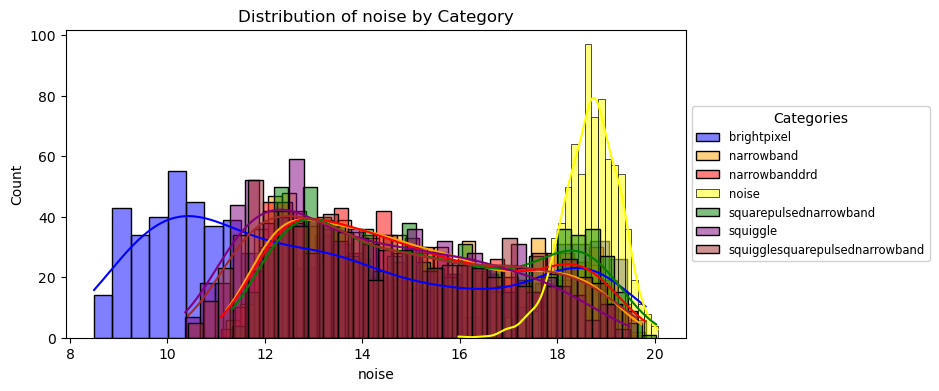

In [193]:
plot_features_distribution(['noise'], gaussian_noise_df)

Just like the *mean* and the *variance* indicators, it looks like the *Gaussian noise* indicator as also a great separator of **noise** category from the rest (not surprising...), and potentially of **brightpixel** as well.

In order to find some interesting insights about the rest of the categories, we will try now a different approach and analyze the frequencies of the spectrograms:

#### <a id='2_3_3'>2.3.3 Frequency Domain Analysis</a>

**Frequency Domain Analysis** is a powerful technique used in image processing to examine the frequency components of an image. This analysis transforms an image from the spatial domain (where pixel values are analyzed) to the frequency domain, where the image is represented by its frequency components.

The core of **Frequency Domain Analysis** is the `Fourier Transform`, which decomposes an image into its constituent frequencies. So, we need to start with understanding `Fourier Transform` meaning:

In the picture below, we can see the **Time Domain** representation of a audio signal, which shows the "loudness" (amplitude) of sounds wave changing with time. To better understand an audio signal, it is necessary to transform it into the **Frequency Domain** representation. This representation of a signal tells us what different frequencies are present in the signal.<br></br>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*e-_z80BnbHWyFTfRLblJ_w.gif" width="400"><br></br>
`Fourier Transform` is a mathematical concept that can *decompose a signal into its constituent frequencies*. In its 2D plot output, the x-axis represent the signal frequencies and the y-axis represent their magnitudes (amplitude size). There is also `Inverse Fourier Transform` concept, which is just the opposite of the Fourier Transform.<br></br>
 For a better understanding of Fourier Transform output - let's create two simple sine waves, with two different frequencies:  *amplitude = 1 and frequency = 3* and *amplitude = 2 and frequency = 11*.
 Now, we can combine them into a single signal, that will look like that - <br></br>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*WBldOpArJgDXIFs5g_JydA.png" width="400"><br></br>
The output of Fourier Transform will show two spikes  for the two frequencies and their magnitudes <br></br>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*aIyR6XoUYGJp0_3Ug6iEyA.png" width="400"><br></br>
For more information, you can read the article - [understand audio fft](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520)

Having said that, we can use `Fourier Transform` to analyze frequencies of each spectrogram, and to extract some interesting features:
- **Dominant Frequency**: Extract the measure of the dominant frequency's strength
- **Bandwidth**: Calculate the range of frequencies where the signal's power is concentrated.
- **Spectral Centroid**: The "center of mass" of the frequency spectrum, which can indicate whether the frequency content is more concentrated at higher or lower frequencies.
- **Spectral Flatness**: A measure of how flat the spectrum is. Values close to 0 indicate a tonal signal, while values close to 1 indicate a noise-like signal.

In order to extract these features, we will start with apply `Fourier Transform` over our images using `fft` method and calculate its magnitude (which is the intensity of each frequency component in the transformed domain) and frequency bins (an array of indices that correspond to the frequency bins of the magnitude spectrum):

In [196]:
def apply_fft(grayscale_image):
    spectrogram = np.array(grayscale_image)

    # Create 1D array of the average power of frequencies over the entire spectrogram time span
    frequencies = np.mean(spectrogram, axis=1)
    frequencies_amount = len(frequencies)

    # Apply Fourier Transform to get amplitudes array of different frequencies components.
    frequencies_amplitudes = fft(frequencies) / frequencies_amount
    
    # Calculate the intensity of each frequency component in the transformed domain.
    magnitude = np.abs(frequencies_amplitudes[:frequencies_amount//2])

    # Create an array of the discrete frequency components that make up the original signal.
    frequency_bins = np.arange(len(magnitude))

    return magnitude, frequency_bins

In [197]:
# Get the measure of the most dominant frequency
def get_max_magnitude(magnitude):
    return np.max(magnitude)

# Get the center of the mass of the spectrum
def get_spectral_centroid(magnitude, frequency_bins):
    return np.sum(frequency_bins * magnitude) / np.sum(magnitude)

# Get the std of the frequencies distribution
def get_bandwidth(magnitude, frequency_bins, spectral_centroid):
    return np.sqrt(np.sum(((frequency_bins - spectral_centroid) ** 2) * magnitude) / np.sum(magnitude))

# Get spectral flatness by the ration of geometric mean to arithmetic mean
def get_spectral_flatness(magnitude):
    geometric_mean = np.exp(np.sum(np.log(magnitude[magnitude > 0])) / len(magnitude[magnitude > 0]))
    arithmetic_mean = np.mean(magnitude)

    return geometric_mean / arithmetic_mean

Now, we can extract these features from our traning set and analyze the results:

In [198]:
fft_features_list = []

for _, row in train_df.iterrows():
    image_id = row['file_id']
    image = get_grayscale_image(row['file_path'])

    magnitude, frequency_bins = apply_fft(image)
    
    spectral_centroid = get_spectral_centroid(magnitude, frequency_bins)

    fft_features_list.append({
        'id': row['file_id'],
        'category': row['category'],
        'spectral_flatness': get_spectral_flatness(magnitude),
        'spectral_centroid': spectral_centroid,
        'bandwidth': get_bandwidth(magnitude, frequency_bins, spectral_centroid),
        'max_magnitude': get_max_magnitude(magnitude)
    })

fft_features_df = pd.DataFrame(fft_features_list)

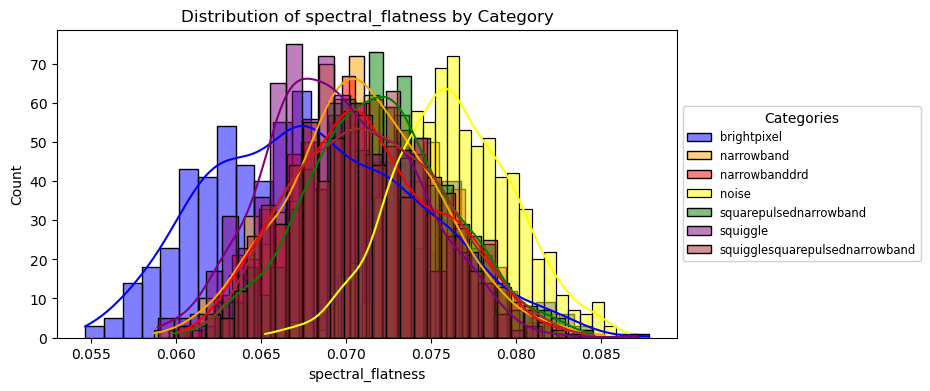

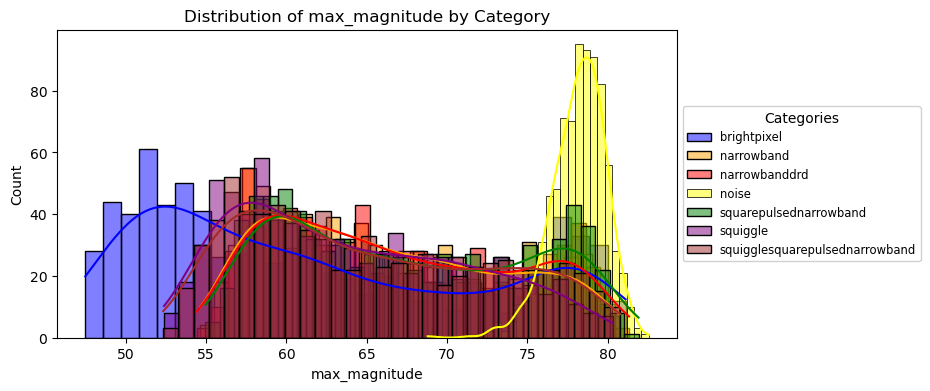

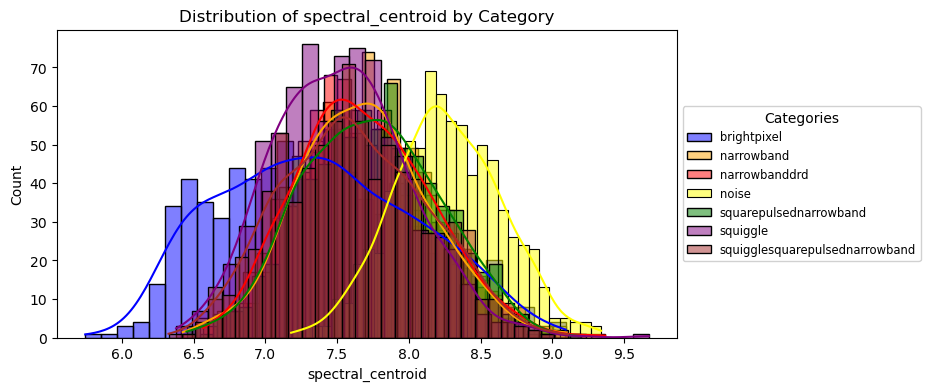

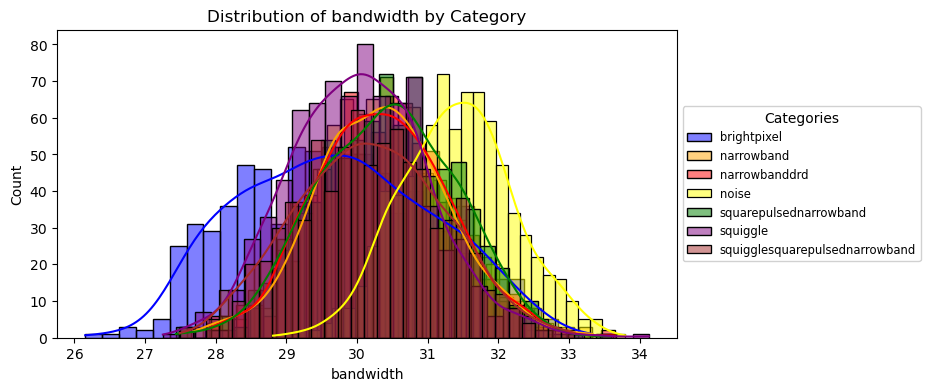

In [199]:
plot_features_distribution(['spectral_flatness', 'max_magnitude', 'spectral_centroid', 'bandwidth'], fft_features_df)

Looks like the *spectral_centroid* and the *bandwidth* metrics may be good separators of the **squiggle** category from the rest, because it has narrower value for the **squiggle** data samples. We will use *max_magnitude* as well because it detects well samples from the **noise** category, and we can give up on the *spectral_flatness* who doesnt seem so helpful.

#### <a id='2_3_4'>2.3.4 Signal Measurements</a>
After applying the `Fourier Transform` to measure signal frequencies, we will employ a more creative approach to determine each signal's **length**, the number of **connected components**, number of **zigzags**, as well as its **width** and **height**. These features can serve as effective discriminators among the different categories.

To calculate these measurements, we first need to detect the main signal within the entire spectrogram. For this purpose, we will utilize the `Canny Edge Detection` algorithm. This method involves several steps: applying Gaussian blurring for noise reduction, calculating gradients to identify edge strength and direction, performing non-maximum suppression to thin the edges, and using hysteresis thresholding to retain strong edges while discarding weak ones.

In [145]:
def get_signal(grayscale_img, min_threshold=100, max_threshold=350):
    return cv2.Canny(grayscale_img, threshold1=min_threshold, threshold2=max_threshold)

Let's take a look on the results:

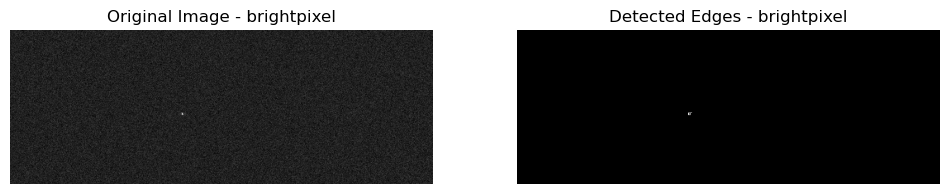

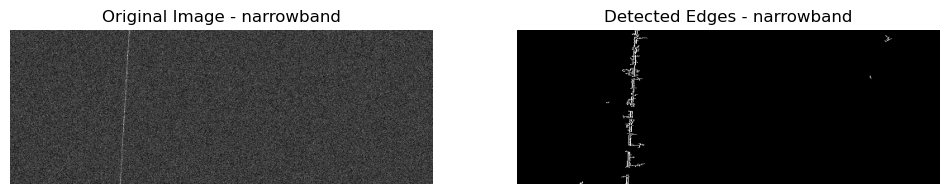

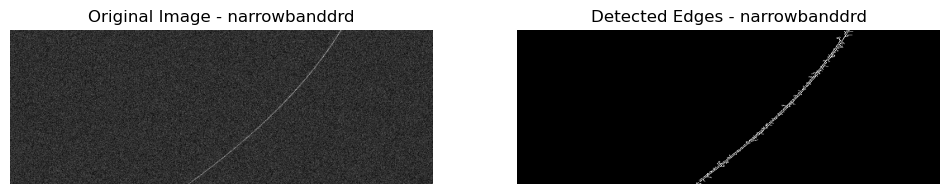

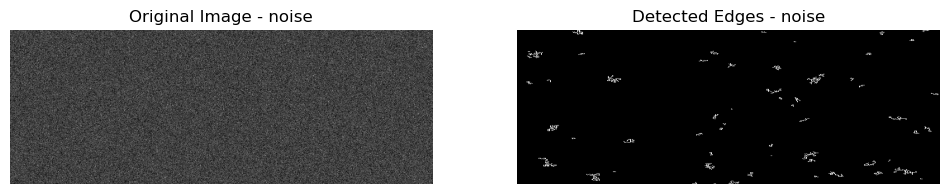

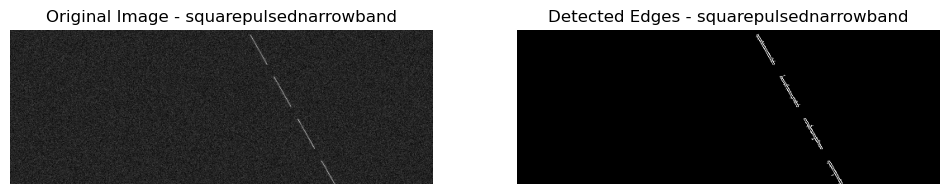

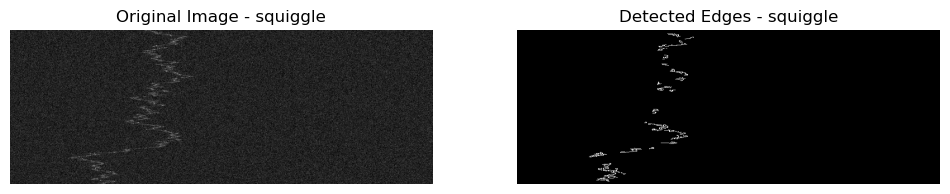

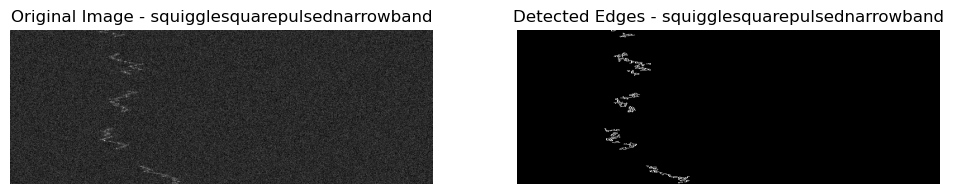

In [159]:
def plot_detected_edges(base_folder, category, image_id):
    grayscale_image = get_grayscale_image(get_image_path(base_folder, category, image_id))

    plt.figure(figsize=(12,2))
    plt.subplot(1, 2, 1)
    plt.title(f'Original Image - {category}')
    plt.imshow(grayscale_image, cmap='gray', aspect='auto')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'Detected Edges - {category}')
    plt.imshow(get_signal(grayscale_image), cmap='gray', aspect='auto')
    plt.axis('off')

    plt.show()

# Main
plot_detected_edges(CFG.train_folder_path, 'brightpixel', '1018_brightpixel')
plot_detected_edges(CFG.train_folder_path, 'narrowband', '1012_narrowband')
plot_detected_edges(CFG.train_folder_path, 'narrowbanddrd', '1013_narrowbanddrd')
plot_detected_edges(CFG.train_folder_path, 'noise', '761_noise')
plot_detected_edges(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband')
plot_detected_edges(CFG.train_folder_path, 'squiggle', '21_squiggle')
plot_detected_edges(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband')

Looking Amazing! as we can see - the **Canny Edge Detection** algorithm allows us to convert a grayscale image into a binary image (black and white only). The most advantageous aspect of this method is that it effectively **transforms most of the image noise into a value of 0, while the majority of the actual signal is represented by a value of 255!**

However, some pixels not associated with the signal may still appear as part of it. To address this issue, we should remove the small contours from the image, as these isolated pixels contrast with the continuous nature of the signal:

In [154]:
def remove_small_contours(detected_edges_image, min_contour_area=3):
    contours, _ = cv2.findContours(detected_edges_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask to draw the large contours
    mask = np.zeros_like(detected_edges_image)

    # Loop through the contours and draw only the large ones
    for contour in contours:
        if cv2.contourArea(contour) > min_contour_area:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

    # Create an image to display the results
    image_without_small_contours = cv2.bitwise_and(detected_edges_image, detected_edges_image, mask=mask)
    
    return image_without_small_contours

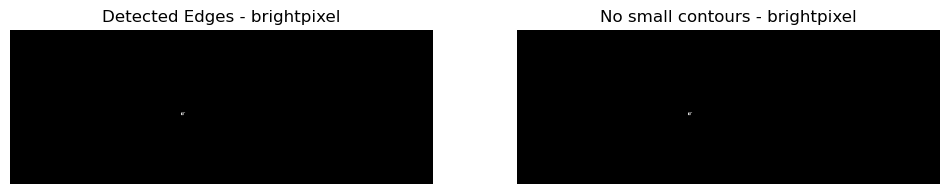

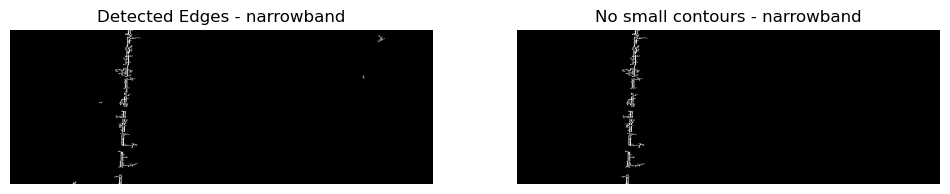

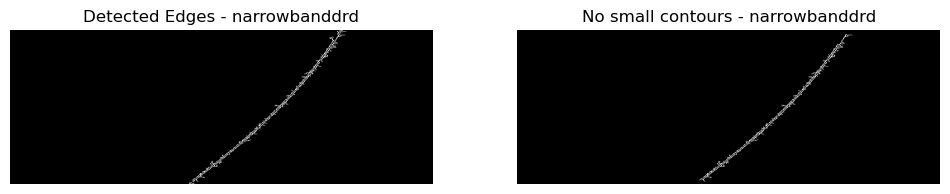

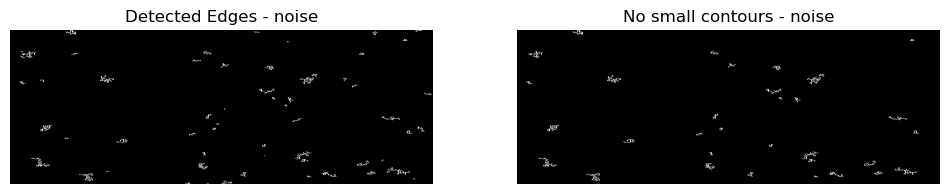

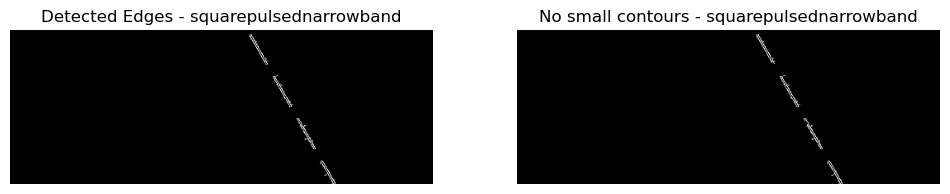

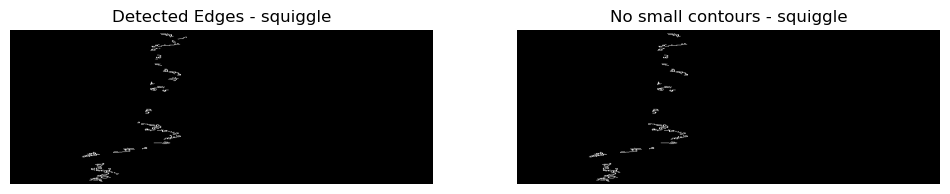

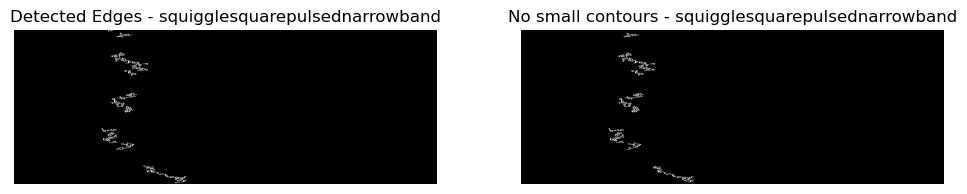

In [155]:
def plot_adjusted_detected_edges(base_folder, category, image_id):
    grayscale_image = get_grayscale_image(get_image_path(base_folder, category, image_id))
    detected_edges_image = get_signal(grayscale_image)

    plt.figure(figsize=(12,2))
    plt.subplot(1, 2, 1)
    plt.title(f'Detected Edges - {category}')
    plt.imshow(detected_edges_image, cmap='gray', aspect='auto')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'No small contours - {category}')
    plt.imshow(remove_small_contours(detected_edges_image), cmap='gray', aspect='auto')
    plt.axis('off')

    plt.show()

# Main
plot_adjusted_detected_edges(CFG.train_folder_path, 'brightpixel', '1018_brightpixel')
plot_adjusted_detected_edges(CFG.train_folder_path, 'narrowband', '1012_narrowband')
plot_adjusted_detected_edges(CFG.train_folder_path, 'narrowbanddrd', '1013_narrowbanddrd')
plot_adjusted_detected_edges(CFG.train_folder_path, 'noise', '761_noise')
plot_adjusted_detected_edges(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband')
plot_adjusted_detected_edges(CFG.train_folder_path, 'squiggle', '21_squiggle')
plot_adjusted_detected_edges(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband')

This adjustment allows us to more accurately estimate the signal's measurements. It's important to note that the removal of contours may negatively impact images from the **brightpixel** category. However, we will extract additional features that can effectively differentiate this category in our models.

Now, let's begin with the length estimation:

In [176]:
def get_estimated_signal_length(image_without_small_contours):
    return np.sum(image_without_small_contours == 255)

# Main
grayscale_image = get_grayscale_image(get_image_path(CFG.train_folder_path, 'narrowbanddrd', '1013_narrowbanddrd'))
detected_edges_image = get_signal(grayscale_image)
image_without_small_contours = remove_small_contours(detected_edges_image)

print(f'estimated length of {get_estimated_signal_length(image_without_small_contours)} pixels')

estimated length of 1007 pixels


Now, we can proceed to estimate the connected components. Before doing so, we need to fill in small gaps within the signal shape, as these gaps can affect the accuracy of the connected components calculations. To fill these gaps, we will employ the `closing` morphological filter.

The `closing` morphological operation is a process that effectively filling small holes and gaps within an object's contours in a binary image. This technique helps enhance the connectivity of shapes and eliminates small imperfections, making it particularly useful for improving the accuracy of subsequent image analysis tasks, such as connected components estimation.

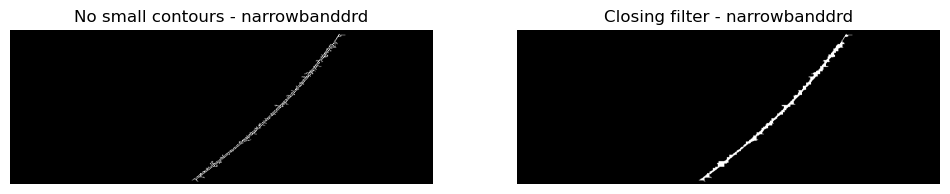

In [181]:
def get_closed_image(image_without_small_contours):
    closing_kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(image_without_small_contours, cv2.MORPH_CLOSE, closing_kernel)

# Plot the difference
plt.figure(figsize=(12,2))
plt.subplot(1, 2, 1)
plt.title(f'No small contours - narrowbanddrd')
plt.imshow(image_without_small_contours, cmap='gray', aspect='auto')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Closing filter - narrowbanddrd')
plt.imshow(get_closed_image(image_without_small_contours), cmap='gray', aspect='auto')
plt.axis('off')

plt.show()

Looking Great. Now, we can proceed with analyzing the estimated connected components:

In [177]:
def get_estimated_connected_components(image_without_small_contours):
    closed_image = get_closed_image(image_without_small_contours)

    num_labels, _ = cv2.connectedComponents(closed_image)
    return num_labels - 1

# Main
print(f'estimated connected components is {get_estimated_connected_components(image_without_small_contours)}')

estimated connected components is 1


Now, we can move on to the more challenging task of determining the **width** and **height** of a signal. To accomplish this, we will create a bounding box around the signal. The process of finding this bounding box involves identifying one pixel from the signal for each edge of the box. Therefore, we will search for the uppermost, lowest, rightmost, and leftmost pixels, all of which have a value of 255, to construct our bounding box.

In [160]:
def find_bounding_box_pixels_edges(image):
    # Find pixels within the specified brightness range
    mask = (image == 255)
    
    # Find coordinates of pixels within the range
    coordinates = np.column_stack(np.where(mask))
    
    if coordinates.size == 0:
        return (0, 0), (0, 0), (0, 0), (0, 0)  # No pixels found in the specified range
    
    upmost_pixel = coordinates[np.argmin(coordinates[:, 0])]
    downiest_pixel = coordinates[np.argmax(coordinates[:, 0])]
    leftmost_pixel = coordinates[np.argmin(coordinates[:, 1])]
    rightmost_pixel = coordinates[np.argmax(coordinates[:, 1])]

    return tuple(upmost_pixel), tuple(downiest_pixel), tuple(leftmost_pixel), tuple(rightmost_pixel)

Let's examine the way it looks on some random images:

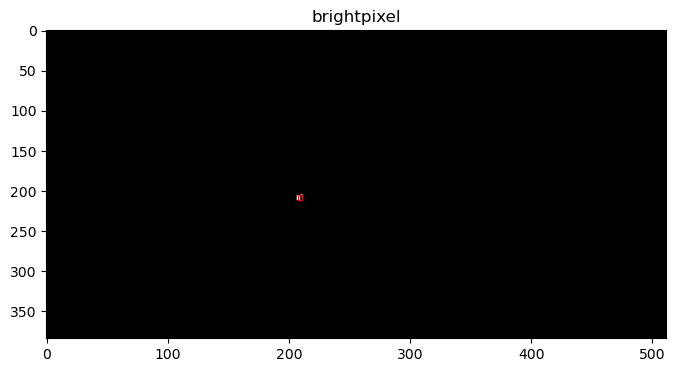

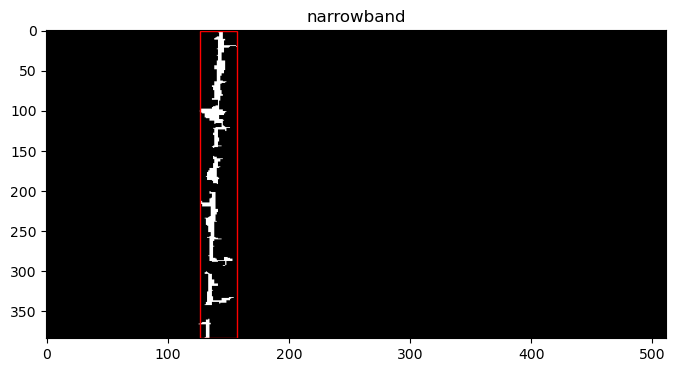

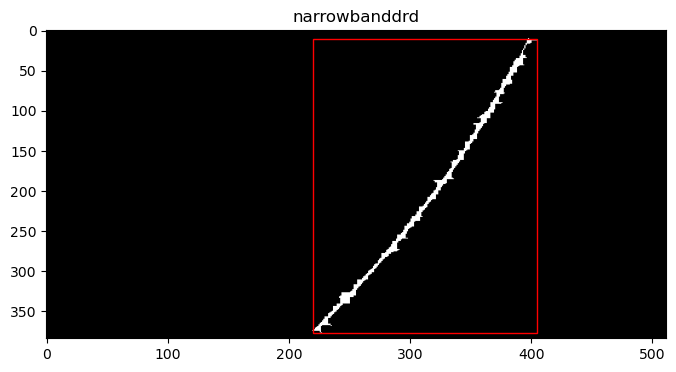

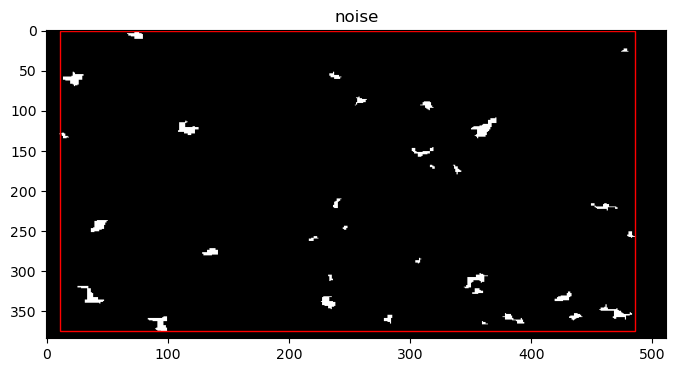

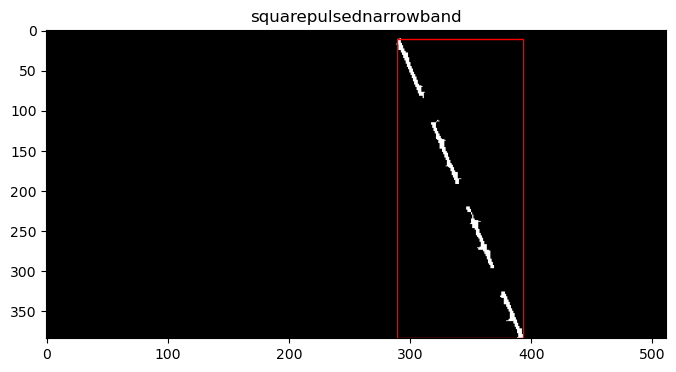

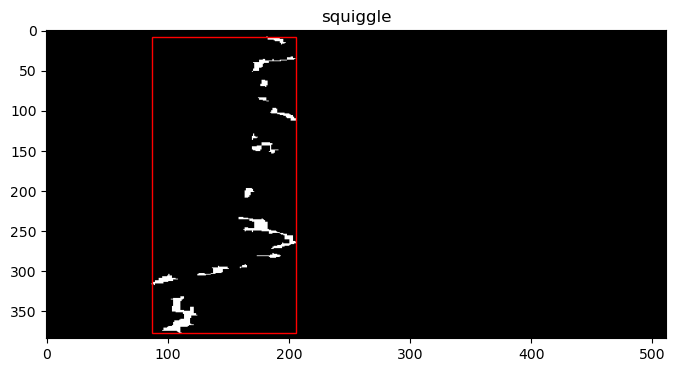

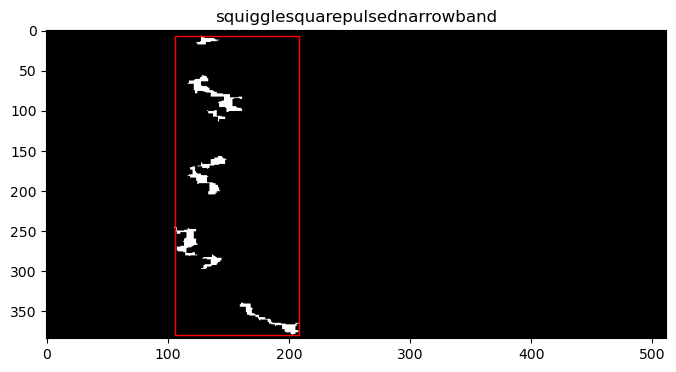

In [182]:
def plot_signal_bounding_box(base_folder, category, image_id):
    image = get_grayscale_image(get_image_path(base_folder, category, image_id))
    image = remove_small_contours(get_signal(image))
    image = get_closed_image(image)
    
    upmost, downiest, leftmost, rightmost = find_bounding_box_pixels_edges(image)
    
    _, ax = plt.subplots(figsize=(8, 4))
    
    ax.set_title(category)
    ax.imshow(image, cmap='gray', aspect='auto')

    bounding_box = patches.Rectangle(
        (leftmost[1], upmost[0]),  # (x, y) for the rectangle (leftmost, upmost)
        rightmost[1] - leftmost[1],  # width
        downiest[0] - upmost[0],     # height
        linewidth=1, edgecolor='r', facecolor='none'
    )
    
    ax.add_patch(bounding_box)
    
    plt.show()

# Main
plot_signal_bounding_box(CFG.train_folder_path, 'brightpixel', '1018_brightpixel')
plot_signal_bounding_box(CFG.train_folder_path, 'narrowband', '1012_narrowband')
plot_signal_bounding_box(CFG.train_folder_path, 'narrowbanddrd', '1013_narrowbanddrd')
plot_signal_bounding_box(CFG.train_folder_path, 'noise', '761_noise')
plot_signal_bounding_box(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband')
plot_signal_bounding_box(CFG.train_folder_path, 'squiggle', '21_squiggle')
plot_signal_bounding_box(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband')

Pretty cool! After successfully identifying the bounding box, determining the width and height of the signal becomes straightforward—the width and height of the signal are simply the dimensions of the bounding box:

In [166]:
def get_estimated_signal_width(image):
    _, _, leftmost, rightmost = find_bounding_box_pixels_edges(image)
    
    return rightmost[1] - leftmost[1]
    
def get_estimated_signal_height(image):
    upmost, downiest, _, _ = find_bounding_box_pixels_edges(image)

    return downiest[0] - upmost[0]

# Main
grayscale_image = get_grayscale_image(get_image_path(CFG.train_folder_path, 'narrowband', '1012_narrowband'))
detected_edges_image = get_signal(grayscale_image)
image_without_small_contours = remove_small_contours(detected_edges_image)

print(f'estimated width of {get_estimated_signal_width(image_without_small_contours)} pixels')
print(f'estimated height of {get_estimated_signal_height(image_without_small_contours)} pixels')

estimated width of 31 pixels
estimated height of 383 pixels


The final feature we will extract is the number of **zigzags** in the signal. To accomplish this, we will apply the `Shi-Tomasi Corner Detection` algorithm. This algorithm identifies significant corners in an image by analyzing the intensity variations in the local neighborhood, allowing us to pinpoint sharp changes in direction. By detecting these corners, we can effectively quantify the number of zigzag patterns present in the signal:

In [183]:
def shi_tomasi_corner_detection(image, min_distance=10):
    # Convert the image to uint8 (required by goodFeaturesToTrack)
    image_uint8 = np.uint8(image)

    max_corners = 100  
    quality_level = 0.05

    corners = cv2.goodFeaturesToTrack(image_uint8, max_corners, quality_level, min_distance)
    if corners is None:
        return []
    else:
        corners = np.intp(corners)

    sorted_corners = sorted(corners, key=lambda pt: pt[0][1])

    # Filter corners based on minimum horizontal distance
    filtered_corners = []
    last_x = -float('inf')  # Set an initial very low value for comparison

    for corner in sorted_corners:
        x, y = corner.ravel()
        if abs(x - last_x) >= min_distance:  
            filtered_corners.append([x, y])
        last_x = x 

    return np.array(filtered_corners)

In [188]:
def get_estimated_zigzags(image):
    return len(shi_tomasi_corner_detection(image))

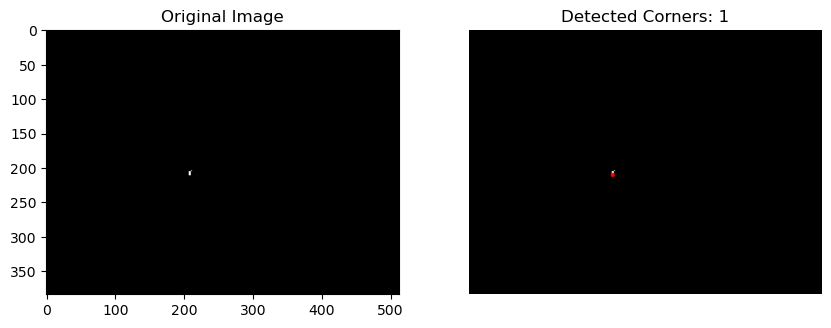

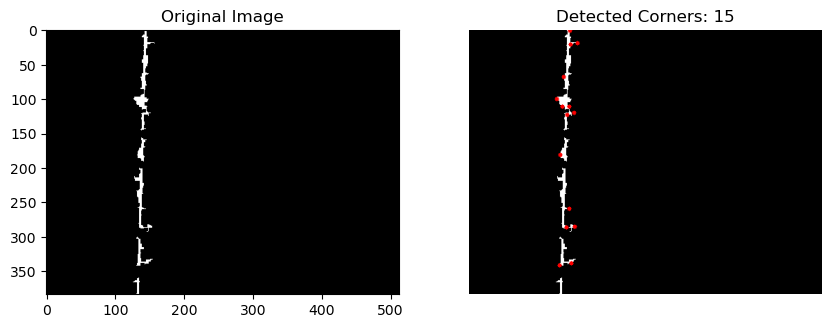

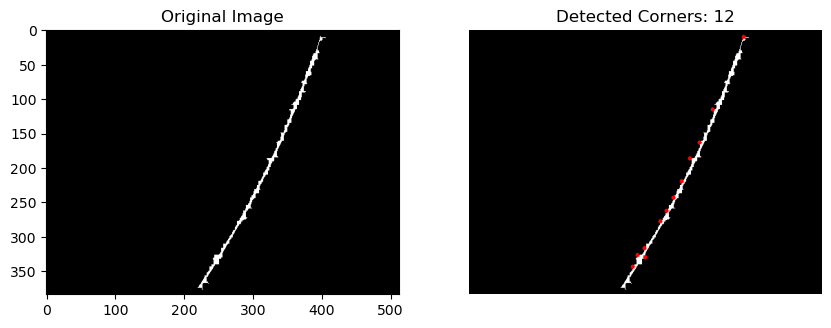

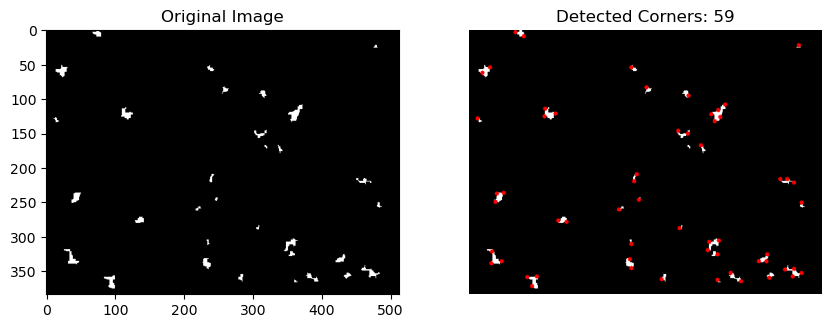

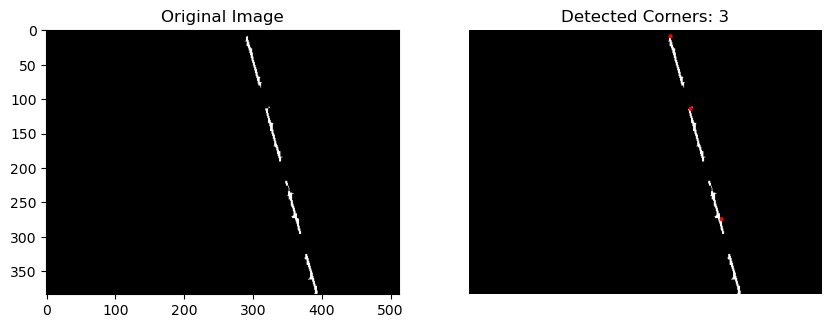

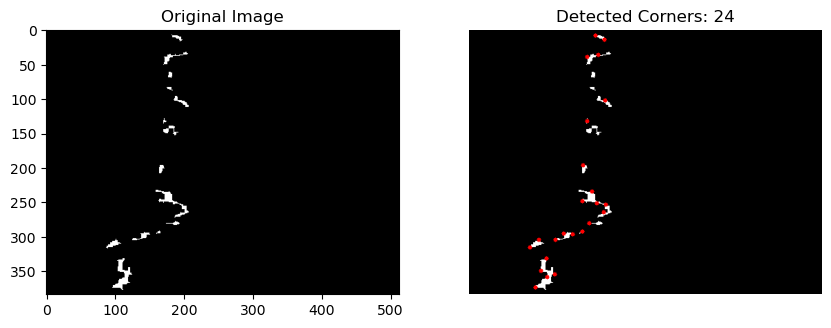

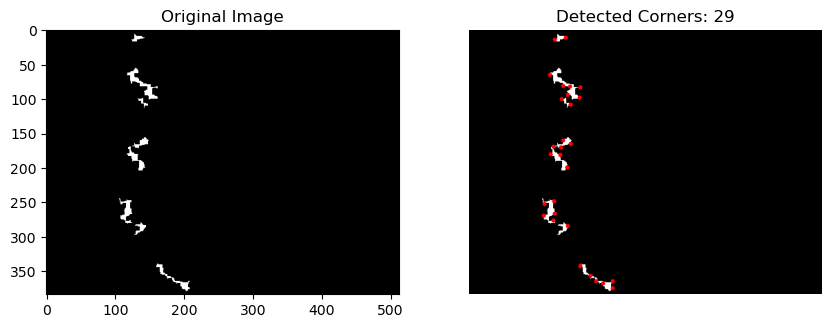

In [187]:
def display_signal_corners(base_folder, category, image_id):
    image = get_grayscale_image(get_image_path(base_folder, category, image_id))
    image = remove_small_contours(get_signal(image))
    image = get_closed_image(image)
    filtered_corners = shi_tomasi_corner_detection(image)
    
    image_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for corner in filtered_corners:
        x, y = corner
        cv2.circle(image_with_corners, (x, y), 3, (255, 0, 0), -1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(image_with_corners, cmap='gray')
    plt.title(f'Detected Corners: {len(filtered_corners)}')
    
    plt.axis('off')
    plt.show()

# Main
display_signal_corners(CFG.train_folder_path, 'brightpixel', '1018_brightpixel')
display_signal_corners(CFG.train_folder_path, 'narrowband', '1012_narrowband')
display_signal_corners(CFG.train_folder_path, 'narrowbanddrd', '1013_narrowbanddrd')
display_signal_corners(CFG.train_folder_path, 'noise', '761_noise')
display_signal_corners(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband')
display_signal_corners(CFG.train_folder_path, 'squiggle', '21_squiggle')
display_signal_corners(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband')

Amazing. The last feature we extracted shows promise as a distinguishing characteristic. 

Now, it's time to analyze these three features across our entire training set:

In [189]:
measurements_features_list = []

for _, row in train_df.iterrows():
    image_id = row['file_id']

    image = get_grayscale_image(row['file_path'])
    image = remove_small_contours(get_signal(image))
    image = get_closed_image(image)

    measurements_features_list.append({
        'id': row['file_id'],
        'category': row['category'],
        'length': get_estimated_signal_length(image),
        'connected_components': get_estimated_connected_components(image),
        'width': get_estimated_signal_width(image),
        'height': get_estimated_signal_height(image),
        'zigzags': get_estimated_zigzags(image)
    })

measurements_features_df = pd.DataFrame(measurements_features_list)

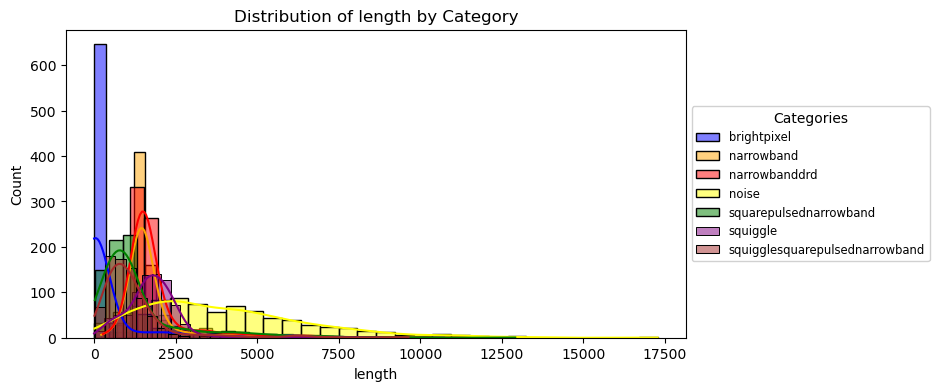

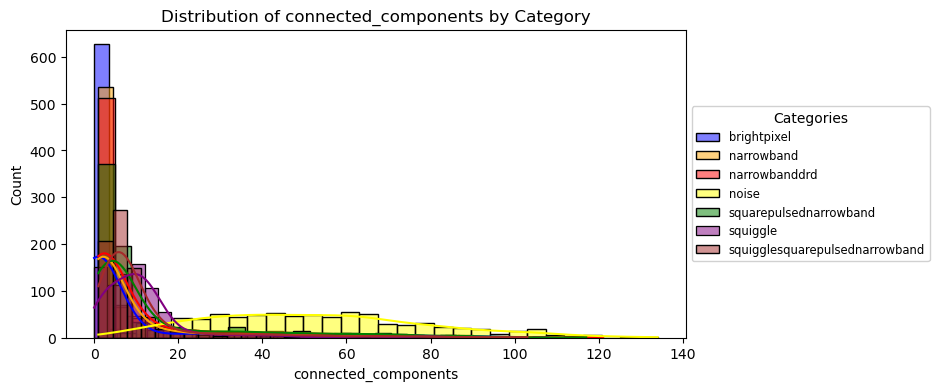

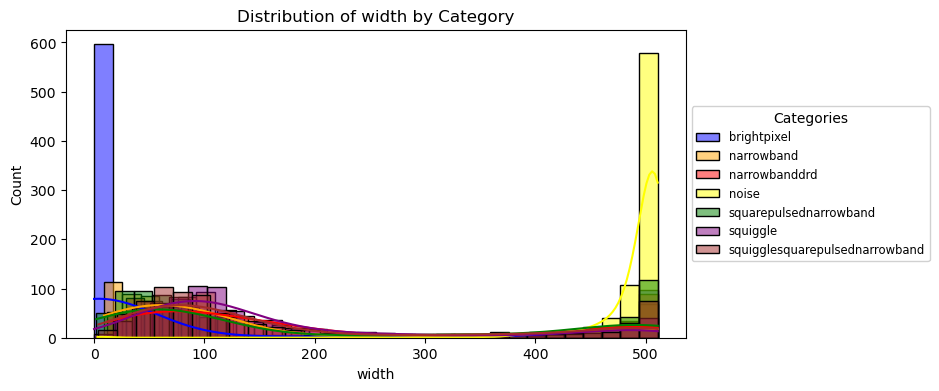

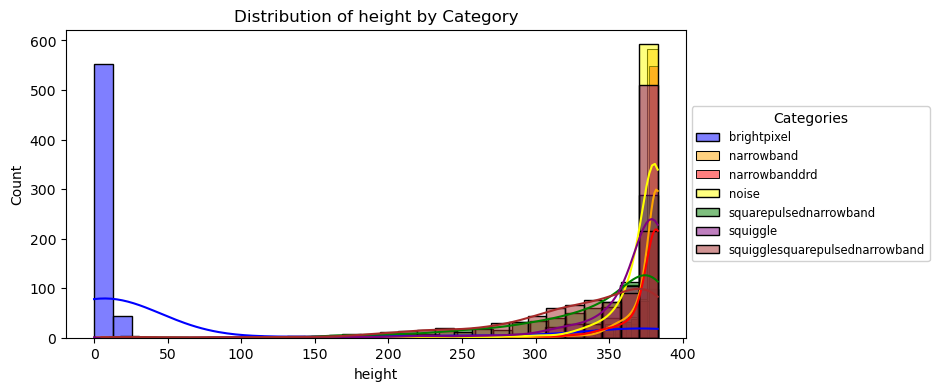

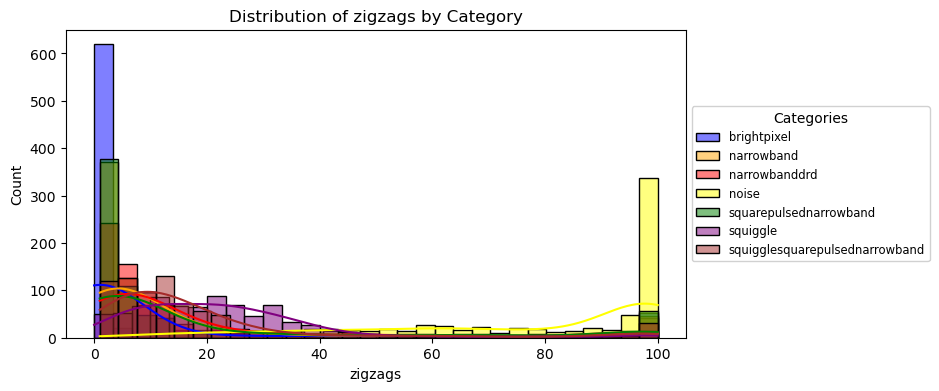

In [200]:
plot_features_distribution(['length','connected_components', 'width', 'height', 'zigzags'], measurements_features_df)

Nice! Beside the fact that the **brightpixel** and the **noise** categories are easy to detect in these plots, we can find some more interesting insights: The length of the **narrowband** and the **narrowbanddrd** tends to be higher than the **squiggle**, **squarepulsednarrowband** and **squigglesquarepulsednarrowband** categories. We can also see that the height of **squigglesquarepulsednarrowband** tends to be pretty low.

We have done working on our *Feature Extraction* techniques for now. In the next sections, we will use pre-trained models features extractions as well - but for now, we can move forward to our next chapter - **Clustering**:

#### <a id='2_3_5'>2.3.5 SIFT</a>

Thanks to Chapter *2.3.4*, we enhanced the visibility of the signals and removed a significant amount of noise, allowing us to apply some popular and traditional feature extraction techniques. The first technique we will explore is `SIFT`. Before diving into the `SIFT` results, we can create a preprocessing function for the signal images based on Chapter *2.3.4* to avoid code duplication:

In [205]:
def preprocess_image(image):
    image = get_grayscale_image(image)
    image = remove_small_contours(get_signal(image))
    image = get_closed_image(image)

    return image

Having done that, we can move forward to SIFT analyzing:

`SIFT` (Scale-Invariant Feature Transform) is an algorithm used to detect and describe local features in images. It detects features that are invariant to scale, making it effective for images captured at different resolutions. The algorithm identifies **key points** in the image that are stable and distinctive, such as corners, edges, and blobs. For each keypoint, SIFT computes a **descriptor**, a 128-dimensional vector that **characterizes the local image region around the keypoint**. This descriptor is invariant to rotations and translations.

In [204]:
def apply_sift(image):
    sift = cv2.SIFT_create()

    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    keypoints, descriptors = sift.detectAndCompute(image, None)
    draw_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return keypoints, descriptors, draw_keypoints

Now, let's proceed to plot the results of the SIFT analysis over some data samples:

There are 2 keypoints, with (2, 128) descriptors size


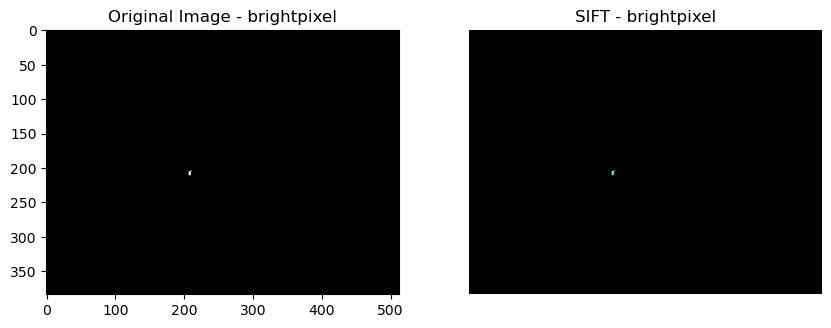

There are 68 keypoints, with (68, 128) descriptors size


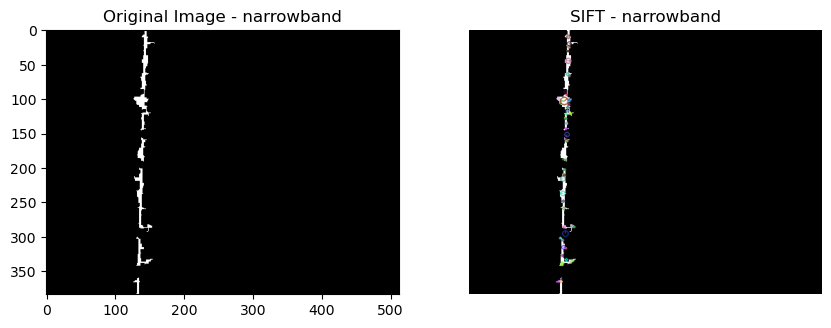

There are 90 keypoints, with (90, 128) descriptors size


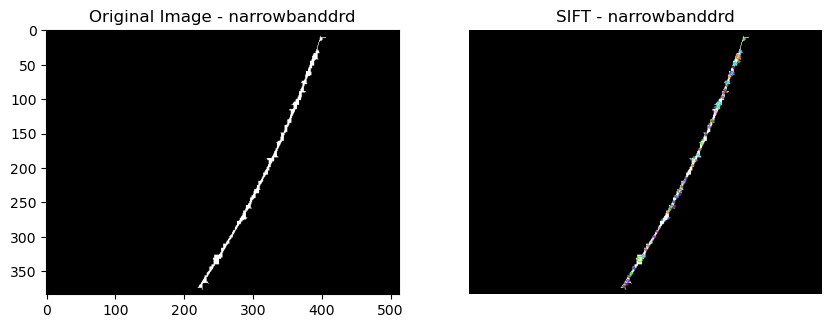

There are 126 keypoints, with (126, 128) descriptors size


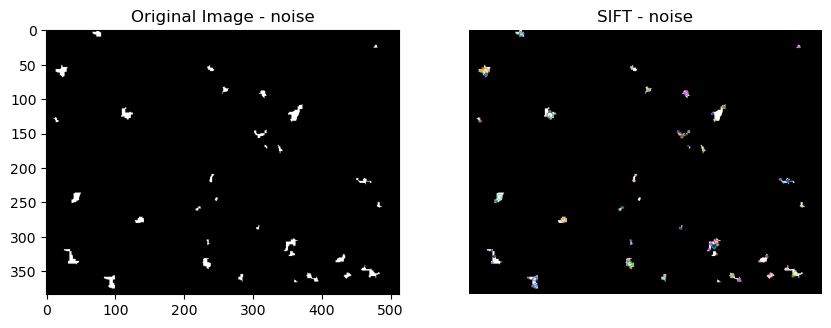

There are 45 keypoints, with (45, 128) descriptors size


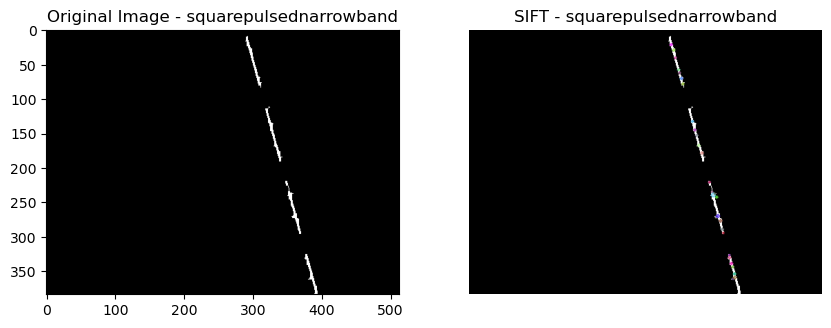

There are 100 keypoints, with (100, 128) descriptors size


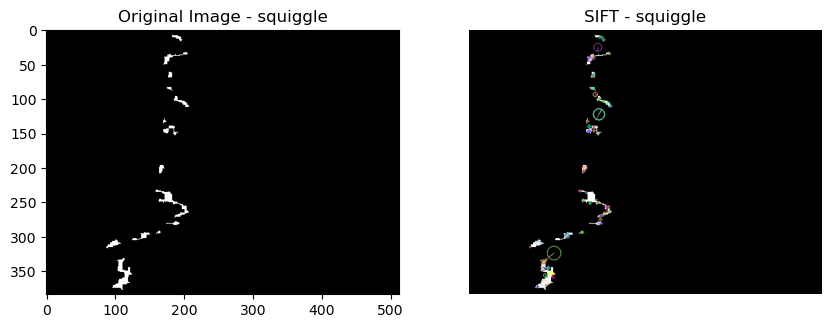

There are 85 keypoints, with (85, 128) descriptors size


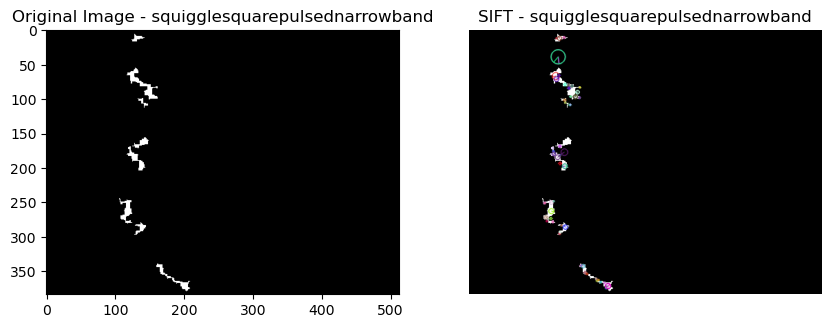

In [206]:
def plot_signal_with_keypoints(base_folder, category, image_id):
    image = preprocess_image(get_image_path(base_folder, category, image_id))
    
    keypoints, descriptors, draw_keypoints = apply_sift(image)

    print(f'There are {len(keypoints)} keypoints, with {descriptors.shape if descriptors is not None else (0, 0)} descriptors size')

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original Image - {category}')
    plt.subplot(1, 2, 2)
    plt.imshow(draw_keypoints, cmap='gray')
    plt.title(f'SIFT - {category}')
    
    plt.axis('off')
    plt.show()

# Main
plot_signal_with_keypoints(CFG.train_folder_path, 'brightpixel', '1018_brightpixel')
plot_signal_with_keypoints(CFG.train_folder_path, 'narrowband', '1012_narrowband')
plot_signal_with_keypoints(CFG.train_folder_path, 'narrowbanddrd', '1013_narrowbanddrd')
plot_signal_with_keypoints(CFG.train_folder_path, 'noise', '761_noise')
plot_signal_with_keypoints(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband')
plot_signal_with_keypoints(CFG.train_folder_path, 'squiggle', '21_squiggle')
plot_signal_with_keypoints(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband')

It appears that the `SIFT` algorithm can effectively identify signal keypoints, yielding a 1x128 keypoint descriptor for each detected feature. In the *Clustering* section, we will utilize `PCA` to reduce the dimensionality of the `SIFT` results, making it easier to work with the data. This dimensionality reduction will help preserve the most important features while minimizing computational complexity, allowing for more efficient clustering and analysis.

To extract meaningful features from the detected keypoints, we can calculate the mean of the `SIFT` descriptors across all keypoints in each image. This step creates a single representative vector for each image, summarizing the local image information captured by the keypoints. The mean calculation is performed by averaging the *128-dimensional* descriptors, resulting in a 1x128 feature vector that encapsulates the essential characteristics of the detected features. By using this mean descriptor, we simplify the data while retaining the significant features that contribute to distinguishing between different signals:

In [209]:
sift_features_list = []

for _, row in train_df.iterrows():
    image_id = row['file_id']
    image = preprocess_image(row['file_path'])

    _, descriptors, _ = apply_sift(image)

    if descriptors is not None:
        sift_features_list.append(descriptors.mean(axis=0))
    else:
        sift_features_list.append(np.zeros(128,))

sift_features_df = pd.DataFrame(data=sift_features_list, columns=[f'SIFT Feature {i}' for i in range(128)])

In [210]:
sift_features_df.head()

SIFT Feature 0  SIFT Feature 1  SIFT Feature 2  SIFT Feature 3  \
0        6.093023        3.418605        0.744186        0.255814   
1        2.500000        0.000000        0.000000        0.000000   
2        8.500000        0.000000        0.000000        0.000000   
3        5.000000       14.750000       14.625000        0.000000   
4        0.000000        0.000000        0.000000        0.000000   

   SIFT Feature 4  SIFT Feature 5  SIFT Feature 6  SIFT Feature 7  \
0        1.767442        1.511628        1.139535        5.534883   
1        0.000000        0.000000        0.000000        3.000000   
2        0.000000        0.000000        0.000000        2.000000   
3        0.000000        0.000000        0.250000        4.625000   
4        0.000000        0.000000        0.000000        0.000000   

   SIFT Feature 8  SIFT Feature 9  ...  SIFT Feature 118  SIFT Feature 119  \
0       27.674419         7.27907  ...           3.55814          1.976744   
1       19.000000         0.00000  ...           0.00000          0.000000   
2       77.500000         0.50000  ...           0.00000          0.500000   
3       22.125000         9.25000  ...           1.00000          0.875000   
4        0.000000         0.00000  ...           0.00000          0.000000   

   SIFT Feature 120  SIFT Feature 121  SIFT Feature 122  SIFT Feature 123  \
0          1.813954          7.627907         14.302325         15.976745   
1          0.000000          0.000000          0.000000          5.000000   
2          0.000000          0.000000          0.000000          1.750000   
3          0.125000         16.875000         15.875000          3.625000   
4          0.000000          0.000000          0.000000          0.000000   

   SIFT Feature 124  SIFT Feature 125  SIFT Feature 126  SIFT Feature 127  
0         10.697675          7.767442          6.139535          0.627907  
1          4.500000          0.000000          0.000000          0.000000  
2         44.250000          7.750000          0.000000          0.000000  
3          1.500000          0.125000          0.750000          0.250000  
4          0.000000          0.000000          0.000000          0.000000  

[5 rows x 128 columns]

In addition to applying `PCA`, we will also analyze the clusters formed from our `SIFT` results in the *Clustering* section. This examination will help us understand the effectiveness of the `SIFT` features for classification purposes. By assessing how well the clusters correspond to the known signal categories, we can evaluate whether the extracted features provide meaningful differentiation between different types of signals.

Now, we can proceed to our final extracted feature:

#### <a id='2_3_6'>2.3.6 HOG</a>

Another popular feature extraction technique - is `HOG`. **Histogram of Oriented Gradients** (`HOG`) is a feature descriptor used in computer vision for object detection. It works by dividing an image into small regions, computing the gradient directions within each region, and then creating a histogram of these orientations. By normalizing these histograms across larger regions, HOG captures the shape and appearance of objects in a way that is robust to changes in illumination and slight deformations

In [212]:
def apply_hog(spectrogram):
    return hog(spectrogram, 
               orientations=9, 
               pixels_per_cell=(8, 8), 
               cells_per_block=(2, 2), 
               block_norm='L2-Hys', 
               visualize=True)

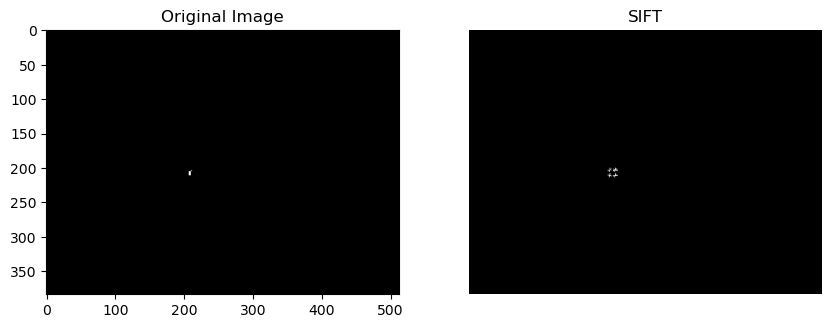

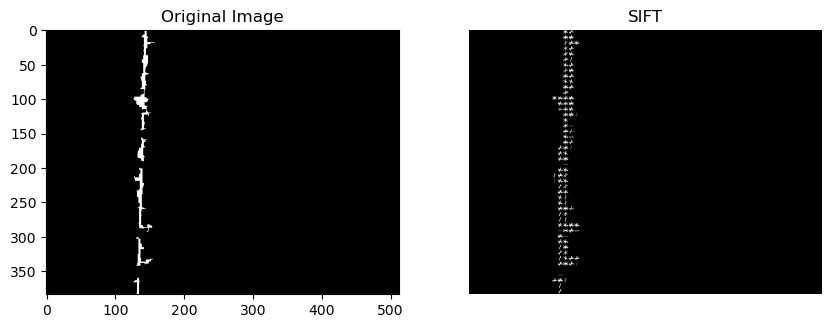

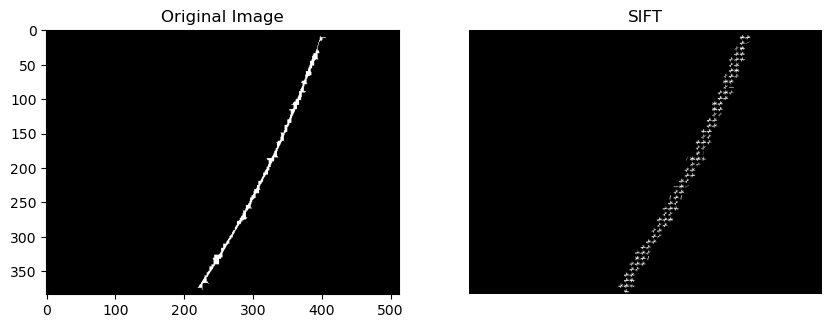

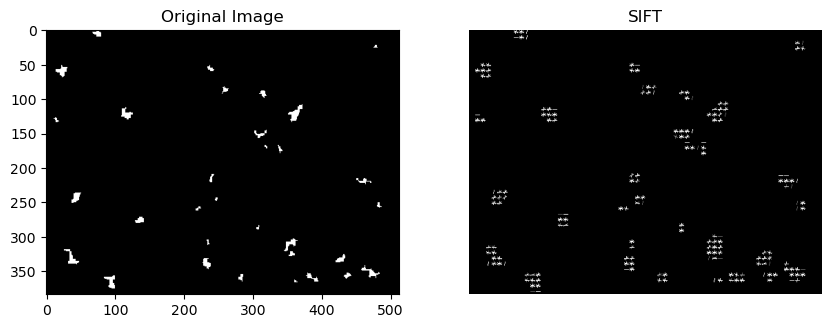

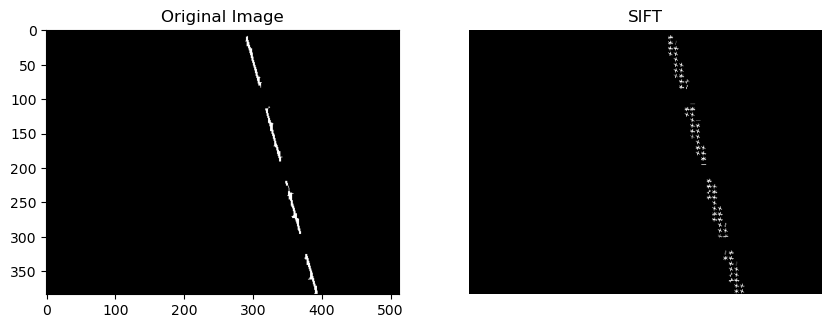

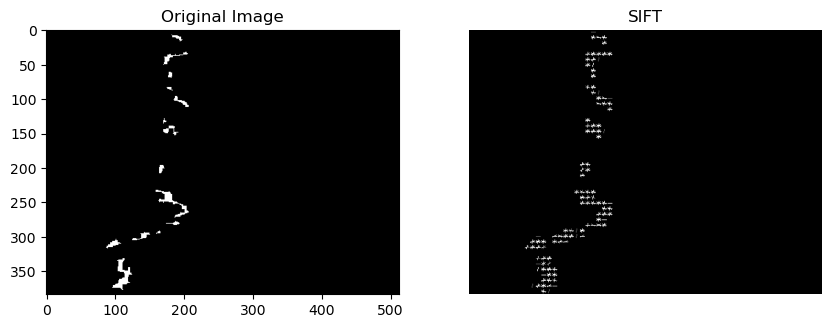

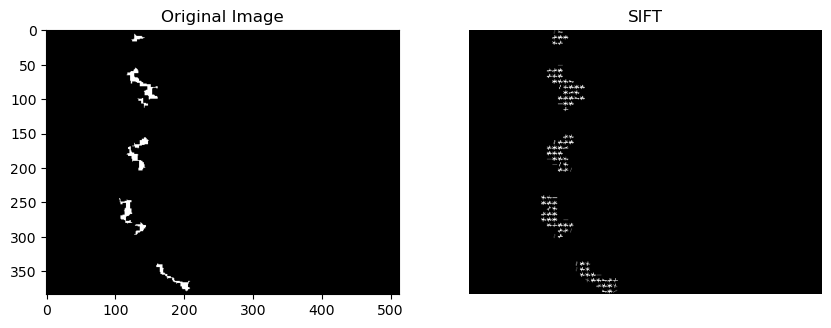

In [213]:
def plot_signal_with_hog(base_folder, category, image_id):
    image = preprocess_image(get_image_path(base_folder, category, image_id))
    
    _, hog_image = apply_hog(image)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title(f'SIFT')
    
    plt.axis('off')
    plt.show()

# Main
plot_signal_with_hog(CFG.train_folder_path, 'brightpixel', '1018_brightpixel')
plot_signal_with_hog(CFG.train_folder_path, 'narrowband', '1012_narrowband')
plot_signal_with_hog(CFG.train_folder_path, 'narrowbanddrd', '1013_narrowbanddrd')
plot_signal_with_hog(CFG.train_folder_path, 'noise', '761_noise')
plot_signal_with_hog(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband')
plot_signal_with_hog(CFG.train_folder_path, 'squiggle', '21_squiggle')
plot_signal_with_hog(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband')

We have completed our work on Feature Extraction techniques for now. In the upcoming sections, we will also utilize feature extraction from pre-trained models. For the time being, however, we can proceed to the next chapters.

Before moving forward, let's compile our complete feature extraction method:

### <a id='2_5'>2.5 Clustering</a>

In order to better understand the data we have been provided with, we need to divide it into categories. In the sections above, we divided the spectrograms to categories based on their noise level, but maybe - there are other intereseting divisions- like *different groups of alien signals* or *different groups of non-alien signals* and more. This division, can be done by using `clustering`. 

Clustering is a process of grouping similar objects together based on their characteristics or features. It is a fundamental unsupervised learning technique which widely used in various domains. It includes several steps:
- **Data Representation**: each data sample should be represented as a vector of features. In our case, we will try using feature extraction.
- **Dimensionality Reduction** (Optional): Sometimes, high-dimensional data can be complex to analyze directly. Dimensionality reduction techniques are used to reduce the number of features while preserving important patterns. We will try to use `PCA`
- **Choosing a Clustering Algorithm**: Select a clustering algorithm based on your data and objectives. Common algorithms include `K-means`, `hierarchical clustering`, and `DBSCAN`. We will try to use `K-means`
- **Run the Algorithm**: Apply the chosen clustering algorithm to the data

Let's start writing the code of a general clustering process, so we will use it later to cluster our signals samples:

#### <a id='2_5_1'>2.5.1 Data Representation</a>

In order to cluster our dataset we need to provide the clustering algorithm our data as one dimentional features vector. The simplest way for doing it, is to flatten our `(6, 273, 256)` cadence snippet into 1D vector in size of **6 * 273 * 256 = 419,328** by using `np.array`:

In [ ]:
def flatten_sample(data_sample):
    return data_sample.flatten()

def flatten_samples(data_samples):
    flattened_data_samples = [flatten_sample(data_sample) for data_sample in data_samples]

    return np.array(flattened_data_samples)

The problem with this way, is that the results are pretty large vectors. Although we can try using Dimensionality reduction methods - the larget the vectors are - the longer the calculation will take. In order to represent our data in a smaller vectors - we will try a few features extraction techniques:

##### <a id='2_5_1_2'> 2.5.1.2. HOG</a>
**Histogram of Oriented Gradients** (HOG) is a feature descriptor used in computer vision for object detection. It works by dividing an image into small regions, computing the gradient directions within each region, and then creating a histogram of these orientations. By normalizing these histograms across larger regions, HOG captures the shape and appearance of objects in a way that is robust to changes in illumination and slight deformations

In [ ]:
def apply_hog(spectrogram):
    return hog(spectrogram, 
               orientations=9, 
               pixels_per_cell=(8, 8), 
               cells_per_block=(2, 2), 
               block_norm='L2-Hys', 
               visualize=True)

Now, we can plot some `hog` results for exploration, using the `apply_cv` first for noise removing:

In [ ]:
def plot_cadence_snippet_with_hog(cadence_snippet, figsize=(11,4), margin=(20,90)):
    _, axes = plt.subplots(nrows=6, ncols=2, figsize=figsize)
    axes[0, 0].set_title('Before HOG', fontsize=10)
    axes[0, 1].set_title('After HOG', fontsize=10)
    
    for i in range(6):
        spectrogram = cadence_snippet[i].astype(np.float32)
        hog_features, hog_image = apply_hog(spectrogram)

        if i ==0:
            print(f'All 6 channels have 1D hog features vector in size of {hog_features.shape[0]}')

        channel_text = 'on' if i % 2 == 0 else 'off'
        channel_box = dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')

        ax_spectrogram = axes[i, 0]
        ax_spectrogram.imshow(spectrogram, aspect='auto', cmap='gray')
        ax_spectrogram.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_spectrogram.axis('off')

        ax_cd = axes[i, 1]
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        ax_cd.imshow(hog_image_rescaled, aspect='auto', cmap='gray')
        ax_cd.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_cd.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main
plot_cadence_snippet_with_hog(apply_cv('0000799a2b2c42d'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_hog(apply_cv('d618b77bb0909c2'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_hog(apply_cv('fffbb1c9c3d6c31'), figsize=(11,4), margin=(10, 50))

The hog results are even worse. Although the results have smaller dimensions, it does not seem like it captures the alien signals at all.

We should move to our last try - a technique called `LBP`:

##### <a id='2_5_1_3'> 2.5.1.3. LBP</a>

`Local Binary Patterns` (LBP) is a texture descriptor that labels the pixels of an image by thresholding the neighborhood of each pixel and treating the result as a binary number. It is particularly effective for texture classification, capturing local texture information by comparing each pixel with its surrounding neighbors. 
The `LBP` calculation is based on two parameters - **radius** and **n_points**:
- **radius** affects the pixel neighborhood that included in the calculation (radius = 1 contains pixels that are directly adjacent to the central pixel, when using a bigger radius - the neighborhood will be bigger as well)
- **n_points** represent the number of sampling points around the central pixel within the specified radius, its typically defined as *8 * radius*

In [ ]:
def apply_lbp(spectrogram):
    radius = 1  
    n_points = 8 * radius  
    spectrogram_uint8 = (spectrogram * 255).astype(np.uint8)

    return local_binary_pattern(spectrogram_uint8, n_points, radius, method='uniform')

In [ ]:
def plot_cadence_snippet_with_lbp(cadence_snippet, figsize=(11,4), margin=(20,90)):
    _, axes = plt.subplots(nrows=6, ncols=2, figsize=figsize)
    axes[0, 0].set_title('Before LBP', fontsize=10)
    axes[0, 1].set_title('After LBP', fontsize=10)
    
    for i in range(6):
        spectrogram = cadence_snippet[i].astype(np.float32)
        lbp = apply_lbp(spectrogram)

        if i == 0 :
            print(f'All 6 channels have 2D lbp features vector in size of {lbp.shape}')

        channel_text = 'on' if i % 2 == 0 else 'off'
        channel_box = dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')

        ax_spectrogram = axes[i, 0]
        ax_spectrogram.imshow(spectrogram, aspect='auto', cmap='gray')
        ax_spectrogram.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_spectrogram.axis('off')

        ax_cd = axes[i, 1]
        ax_cd.imshow(lbp, aspect='auto', cmap='gray')
        ax_cd.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_cd.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main
plot_cadence_snippet_with_lbp(apply_cv('0000799a2b2c42d'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_lbp(apply_cv('d618b77bb0909c2'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_lbp(apply_cv('fffbb1c9c3d6c31'), figsize=(11,4), margin=(10, 50))

The results of the `LBP` is just fine. its dimesions size equals to `cV`dimensions size and its indeed capture the needles signals, but provide a muhc more noisey image than using `cV` only. After trying 4 different popular feature extraction techniques for our cadence snippets representation, we can choose to use flatten `cV` only as our best data representation and move to our next `clustring` step:

#### <a id='2_5_1'>2.5.2 Dimensionality Reduction - PCA</a>

Now, we can move to preforme **Dimensionality Reduction** using `PCA`. `PCA` stands for Principal Component Analysis, a widely used technique that compute the covariance matrix of the data, choose the top k eigenvectors (principal components) corresponding to the largest eigenvalues and project the data onto the selected principal components.

By using `explained_variance_ratio_` metric, we will be able to assess how much of the total variance in our data is captured by each principal component, ensuring we preserve the most important features of the data while potentially reducing dimensionality:

In [ ]:
def pca(data_samples, n):
    pca = PCA(n_components=n)
    pca.fit(data_samples)

    return np.cumsum(pca.explained_variance_ratio_)

def plot_explained_variance(cum_explained_variance, n, sparsity = 1):
    indices = np.arange(n) + 1

    sparse_indices = [1] + list(range(sparsity, indices[-1] + 1, sparsity))
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=indices, y=cum_explained_variance, marker='o', color='b')
    plt.xlabel('Principal Component', fontsize=10)
    plt.ylabel('Cumulative Explained Variance', fontsize=10)
    plt.xticks(ticks=[indices.tolist().index(si) for si in sparse_indices], 
               labels=[str(si) for si in sparse_indices], 
               rotation=0)
    
    plt.show()

# Main
training_set_labels_samples = get_data_set_sample(training_set, 50, 0.1)
training_set_samples = []

for file_id in training_set_labels_samples['id']:
    cv_cadence_snippet = apply_cv(file_id)
    training_set_samples.append(np.vstack(cv_cadence_snippet))

training_set_flatten_samples = flatten_samples(training_set_samples)
cum_explained_variance = pca(training_set_flatten_samples, 30)
plot_explained_variance(cum_explained_variance, 30)

Although we only ran this code over 50 samples, we can learn two interesting things:
- In order to get good ratio of retained variance, the size of `n` should be pretty big in relation to the amount of samples. 
- This basic `PCA` code we've written won'y be good enough when dealing with large amount of data, it keeps all the data sample in the program memory and does all the calculations in one shot - which can cause our app to crash.

Now, we will try writing the `PCA` process again using batched `IncrementalPCA` and run it over **all the alien samples** (6,000 samples): 

In [ ]:
def get_flattened_data(files_id):
    data_list = []
    for file_id in files_id:
        data = apply_cv(file_id)
        data_list.append(np.vstack(data).flatten())
    return np.array(data_list)

def batched_pca_fit(files_id, pca, batch_size):
    for start_index in range(0, len(files_id), batch_size):
        end_index = min(start_index + batch_size, len(files_id))
        batched_files = files_id[start_index:end_index]
        batched_data = get_flattened_data(batched_files)

        # Ensure there are enough samples for PCA
        if batched_data.shape[0] >= pca.n_components:
            pca.partial_fit(batched_data)

def batched_pca_transform(files_id, pca, batch_size):
    transformed_data_list = []

    for start_index in range(0, len(files_id), batch_size):
        end_index = min(start_index + batch_size, len(files_id))
        batched_files = files_id[start_index:end_index]
        batched_data = get_flattened_data(batched_files)

        # Ensure there are enough samples for PCA
        if batched_data.shape[0] >= pca.n_components:
            transformed_data_list.append(pca.transform(batched_data))

    return np.vstack(transformed_data_list)

def run_batched_pca(n_components, batch_size, data_samples):
    pca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    files_id = data_samples['id'].values

    batched_pca_fit(files_id, pca, batch_size)
    transformed_data = batched_pca_transform(files_id, pca, batch_size)
    
    print(f'For n={n_components} - Total variance explained by all components: {np.sum(pca.explained_variance_ratio_)}')

    return transformed_data, pca.explained_variance_ratio_

# Main
batch_size = 1500
n_components = batch_size

train_alien_samples = training_set[training_set['target'] == 1]
test_alien_samples = testing_set[testing_set['target'] == 1]
alien_samples = pd.concat([train_alien_samples, test_alien_samples], ignore_index=True)

transformed_data, explained_variance = run_batched_pca(n_components, batch_size, alien_samples)
plot_explained_variance(np.cumsum(explained_variance), n_components, sparsity=100)

The `PCA` succeeded to reduce the data shape from `(6000, 110040)` to `(6000, 1500)` in a pretty decent variance retain. As we can see in the plot, it takes a large amount of principal components in order to step of from 0.8 retian variance ratio to 0.9+.

For now, it looks like we can keep using this dimensionality reduction technique and move forward to the `K-means` itself:

#### <a id='2_5_3'>2.5.3 K-means</a>
`K-means` clustering algorithm is an iterative algorithm used to partition data into k distinct clusters based on feature similarity.

This algorithm consist a few steps:
1. **Initialization**: The algorithm begins by selecting k initial centroids randomly from the data points.
2. **Assignment**: Each data point is assigned to the nearest centroid, creating k clusters.
3. **Update**: The centroids of the clusters are recalculated as the mean of all data points assigned to each cluster.
4. **Iteration**: Steps 2 and 3 are repeated until the centroids stabilize (i.e., they do not change significantly) or a maximum number of iterations is reached.

For a better understanding, here its workflow:

<img src="https://preview.redd.it/wodjl2e8ffw71.png?width=1121&format=png&auto=webp&s=1a723f05e981efee1519c4999c95c6611c587c0f" width="600"/>

Now, we will write a code that preforme this clustering, using `MiniBatchKMeans` for preforming it in batches:

In [ ]:
def batched_kmeans_fit(data_samples, n_clusters, batch_size):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)

    for start_index in range(0, len(data_samples), batch_size):
        end_index = min(start_index + batch_size, len(data_samples))
        batch_data = data_samples[start_index:end_index]
        kmeans.partial_fit(batch_data)
    
    return kmeans

def batched_kmeans_predictions(kmeans, data_samples, batch_size):
    predictions = []
    
    for start_index in range(0, len(data_samples), batch_size):
        end_index = min(start_index + batch_size, len(data_samples))
        batch_data = data_samples[start_index:end_index]
        predictions.extend(kmeans.predict(batch_data))
    
    return np.array(predictions)

def run_batched_kmeans(data_samples, n_clusters, batch_size):
    kmeans_model = batched_kmeans_fit(data_samples, n_clusters, batch_size)
    predictions = batched_kmeans_predictions(kmeans_model, data_samples, batch_size)

    return kmeans_model, predictions

Great! now it's time to choose our number of clusters - `k`. For doing it, we will use `Silhouette Score` method:
> **Silhouette Score**: computes the silhouette score (measures how similar data point is to its own cluster compared to other clusters) for each data point and choose the optimal `k` that maximize this averege data points score 

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2,11)

for k in k_range:
    kmeans_model, clusters = run_batched_kmeans(transformed_data, k, 250)
    
    score = silhouette_score(transformed_data, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Great! now, we can preforme `k-means` over k=2 and k=5:

In [ ]:
def plot_kmeans_clusters(data_samples_reduced, clusters, k):
    print(f'Clustering for k={k}:')
    cluster_counts = np.bincount(clusters)

    for cluster_id, count in enumerate(cluster_counts):
        print(f'-- Cluster {cluster_id + 1}: {count} items')

    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(data_samples_reduced[:, 0], data_samples_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, ticks=range(k))
    plt.show()

# Main
batch_size = 300
kmeans_model_2, predictions_2 = run_batched_kmeans(transformed_data, 2, batch_size)
kmeans_model_3, predictions_3 = run_batched_kmeans(transformed_data, 3, batch_size)
kmeans_model_5, predictions_5 = run_batched_kmeans(transformed_data, 5, batch_size)

plot_kmeans_clusters(transformed_data, predictions_2, 2)
plot_kmeans_clusters(transformed_data, predictions_3, 3)
plot_kmeans_clusters(transformed_data, predictions_5, 5)

In [ ]:
def plot_candece_snippet_by_clusters(n_clusters, predictions, data_samples, samples_per_cluster):
    for cluster in range(n_clusters):
        cluster_indices = np.where(predictions == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, samples_per_cluster, replace=False)

        selected_spectrograms_id = data_samples.iloc[selected_indices]['id'].values
        selected_spectrograms = np.array([np.load(get_file_path(id, CFG.train_folder_path)) for id in selected_spectrograms_id])

        print(f'Cluster number {cluster + 1}:')
        plot_multiple_cadence_snippets(selected_spectrograms, figsize=(17,15))

# Main
plot_candece_snippet_by_clusters(n_clusters, predictions, alien_samples, 9)